<a href="https://colab.research.google.com/github/Saibhossain/text-to-image-generation/blob/main/Denoising_Diffusion_Probabilistic_Face_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jan  6 15:21:07 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## DDPM



 ### DDPM= Denoising Diffusion Probabilistic Model

- **What it is**: A foundational **generative model** that creates images by **iteratively denoising** random noise.
- **Generation process**:
  1. Start with pure Gaussian noise: $ x_T \sim \mathcal{N}(0, I) $
  2. Apply **hundreds to thousands** of small denoising steps
  3. End with a realistic image: $ x_0 $

- **Mathematical goal**: Learn the reverse process to approximate the data distribution:
  $$
  p_\theta(x_0) = \sum_{t=1}^{T} p_\theta(x_{t-1} \mid x_t)
  $$

**Key idea**: DDPM **does not generate images in one step**—it refines noise gradually over many timesteps (typically $ T = 1000 $).

Introduced in Ho et al. (2020), DDPM is **stable**, **high-quality**, and forms the basis for modern diffusion models like Stable Diffusion.

In [2]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

IMAGE_SIZE = 64        # start small
BATCH_SIZE = 1048
EPOCHS = 50
LR = 2e-4
T = 1000               # diffusion steps

cuda


##  Face Generation Dataset




- **Dataset**: Contains **only human faces** (**FFHQ**, **CelebA-HQ**).
- **Consequences**:
  - The model **implicitly learns facial structure**, proportions, and features.
  - It **cannot generate** objects, animals, landscapes, or non-face content.
  - **All outputs are face-like images**—even when starting from random noise.

**No identity control or attribute manipulation** (age, gender, pose) is built into the base model. It generates **generic, realistic faces** only.

In [3]:
import kagglehub
path = kagglehub.dataset_download("saibhossain/augmented-celebrity-face-6144")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'augmented-celebrity-face-6144' dataset.
Path to dataset files: /kaggle/input/augmented-celebrity-face-6144


In [5]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            return sample, target
        except (UnidentifiedImageError, OSError):
            # skip bad image by loading another one
            new_index = (index + 1) % len(self.samples)
            return self.__getitem__(new_index)


dataset = SafeImageFolder("/kaggle/input/augmented-celebrity-face-6144", transform=transform)
# dataset = ImageFolder("/root/.cache/kagglehub/datasets/saibhossain/augmented-celebrity-face-6144/versions/1", transform=transform)
print("Total images:", len(dataset))

Total images: 6656


In [6]:
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

imgs, _ = next(iter(dataloader))
print("Shape:", imgs.shape)
print("Min:", imgs.min().item())
print("Max:", imgs.max().item())
print("Mean:", imgs.mean().item())
print("Std:", imgs.std().item())

Shape: torch.Size([1048, 3, 64, 64])
Min: -1.0
Max: 1.0
Mean: -0.2365303784608841
Std: 0.5737141370773315






##  What the Model Actually Learns



During training, the model solves one simple task:

 **“Given a partially noisy face at timestep $ t $, predict the noise that was added.”**

- **Training objective (loss function)**:
  $$
  \mathcal{L} = \mathbb{E}_{x_0, t, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
  $$

- **Key insight**:  
  This single **noise-prediction task**—applied across millions of face images and timesteps—enables the model to **reconstruct and generate realistic faces from pure noise** during inference.

Despite its simplicity, this formulation captures the **full complexity of facial appearance** through iterative denoising.

In [22]:
# Debug Noise Schedule
beta = torch.linspace(1e-4, 0.02, T).to(device)
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, dim=0)

print("beta[0]:", beta[0].item(), "beta[T-1]:", beta[-1].item())
print("alpha_hat[0]:", alpha_hat[0].item())
print("alpha_hat[T-1]:", alpha_hat[-1].item())

beta[0]: 9.999999747378752e-05 beta[T-1]: 0.019999999552965164
alpha_hat[0]: 0.9998999834060669
alpha_hat[T-1]: 4.035829260828905e-05


In [23]:
def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]

    x_t = sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise

    print("t[0]:", t[0].item())
    print("sqrt_alpha_hat[0]:", sqrt_alpha_hat[0].item())
    print("x0 mean/std:", x0.mean().item(), x0.std().item())
    print("noise mean/std:", noise.mean().item(), noise.std().item())
    print("x_t mean/std:", x_t.mean().item(), x_t.std().item())

    return x_t, noise


class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, 3, padding=1)

    def forward(self, x, t):
        t = t[:, None, None, None].float() / T
        x = x + t

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return self.conv4(x)

model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(model)

SimpleUNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [24]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)


In [25]:
for epoch in range(EPOCHS):
    loop = tqdm(dataloader)
    for imgs, _ in loop:
        imgs = imgs.to(device)
        t = torch.randint(0, T, (imgs.size(0),)).to(device)
        x_t, noise = forward_diffusion(imgs, t)
        noise_pred = model(x_t, t)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss=loss.item())
        print("loss:", loss.item())

Epoch [1/50]:   0%|          | 0/7 [00:19<?, ?it/s]

t[0]: 432
sqrt_alpha_hat[0]: 0.38444042205810547
x0 mean/std: -0.24439673125743866 0.5727758407592773
noise mean/std: 0.0001212603019666858 1.0001323223114014
x_t mean/std: -0.09894515573978424 0.9015300273895264


Epoch [1/50]:  14%|█▍        | 1/7 [00:21<02:07, 21.26s/it, loss=1]

loss: 0.9997472167015076
t[0]: 680
sqrt_alpha_hat[0]: 0.0952828973531723
x0 mean/std: -0.2400076538324356 0.5750942826271057
noise mean/std: -1.807533590181265e-05 0.9997614622116089
x_t mean/std: -0.09669775515794754 0.9010937809944153


Epoch [1/50]:  29%|██▊       | 2/7 [00:22<00:47,  9.55s/it, loss=0.988]

loss: 0.9883711934089661


Epoch [1/50]:  29%|██▊       | 2/7 [00:38<00:47,  9.55s/it, loss=0.988]

t[0]: 158
sqrt_alpha_hat[0]: 0.8752883076667786
x0 mean/std: -0.24303659796714783 0.5744880437850952
noise mean/std: 5.306138700689189e-05 0.9999750256538391
x_t mean/std: -0.09589014947414398 0.9079574346542358


Epoch [1/50]:  43%|████▎     | 3/7 [00:40<00:52, 13.24s/it, loss=0.978]

loss: 0.9784982204437256
t[0]: 369
sqrt_alpha_hat[0]: 0.49650564789772034
x0 mean/std: -0.2394404113292694 0.5704116225242615
noise mean/std: 0.00016080828208941966 1.0002161264419556
x_t mean/std: -0.09787984937429428 0.9017408490180969


Epoch [1/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.55s/it, loss=0.969]

loss: 0.9690589904785156


Epoch [1/50]:  57%|█████▋    | 4/7 [00:58<00:25,  8.55s/it, loss=0.969]

t[0]: 414
sqrt_alpha_hat[0]: 0.41527602076530457
x0 mean/std: -0.238186314702034 0.5710648894309998
noise mean/std: 0.00012265695841051638 0.9995793700218201
x_t mean/std: -0.09653957933187485 0.9001827836036682


Epoch [1/50]:  71%|███████▏  | 5/7 [00:59<00:23, 11.90s/it, loss=0.957]

loss: 0.957238495349884
t[0]: 88
sqrt_alpha_hat[0]: 0.9574512839317322
x0 mean/std: -0.22868724167346954 0.5772963762283325
noise mean/std: 8.123114821501076e-05 1.0002201795578003
x_t mean/std: -0.0907856673002243 0.9084734916687012


Epoch [1/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.32s/it, loss=0.945]

loss: 0.945378303527832


Epoch [1/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.32s/it, loss=0.945]

t[0]: 819
sqrt_alpha_hat[0]: 0.033235255628824234
x0 mean/std: -0.23866090178489685 0.5623307824134827
noise mean/std: 0.000512923114001751 0.9996664524078369
x_t mean/std: -0.10661239922046661 0.8905172944068909


Epoch [1/50]: 100%|██████████| 7/7 [01:03<00:00,  9.00s/it, loss=0.933]


loss: 0.9334756731987


Epoch [2/50]:   0%|          | 0/7 [00:19<?, ?it/s]

t[0]: 88
sqrt_alpha_hat[0]: 0.9574512839317322
x0 mean/std: -0.22792360186576843 0.5742654204368591
noise mean/std: 5.20683461218141e-05 0.9998490810394287
x_t mean/std: -0.09400953352451324 0.9039720892906189


Epoch [2/50]:  14%|█▍        | 1/7 [00:20<02:05, 20.86s/it, loss=0.918]

loss: 0.9175825119018555
t[0]: 902
sqrt_alpha_hat[0]: 0.016142256557941437
x0 mean/std: -0.242404967546463 0.5699918866157532
noise mean/std: -0.00014967167226132005 1.0001894235610962
x_t mean/std: -0.0901871994137764 0.913539707660675


Epoch [2/50]:  29%|██▊       | 2/7 [00:22<00:46,  9.39s/it, loss=0.899]

loss: 0.8994682431221008


Epoch [2/50]:  29%|██▊       | 2/7 [00:38<00:46,  9.39s/it, loss=0.899]

t[0]: 248
sqrt_alpha_hat[0]: 0.725775957107544
x0 mean/std: -0.2311500757932663 0.5769838690757751
noise mean/std: 0.00042229416430927813 1.000022530555725
x_t mean/std: -0.08955074846744537 0.9049041271209717


Epoch [2/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.11s/it, loss=0.884]

loss: 0.8836223483085632
t[0]: 343
sqrt_alpha_hat[0]: 0.5454180836677551
x0 mean/std: -0.2446170300245285 0.569960355758667
noise mean/std: -0.0006201926153153181 0.9996501803398132
x_t mean/std: -0.09975837171077728 0.8965663909912109


Epoch [2/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.48s/it, loss=0.868]

loss: 0.8682662844657898


Epoch [2/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.48s/it, loss=0.868]

t[0]: 508
sqrt_alpha_hat[0]: 0.2677680552005768
x0 mean/std: -0.2400510013103485 0.5731069445610046
noise mean/std: -5.2700535889016464e-05 0.9999642372131348
x_t mean/std: -0.09205349534749985 0.9074176549911499


Epoch [2/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.78s/it, loss=0.844]

loss: 0.8444300889968872
t[0]: 166
sqrt_alpha_hat[0]: 0.863663375377655
x0 mean/std: -0.24772188067436218 0.5736355185508728
noise mean/std: 2.7358360966900364e-05 0.9999547600746155
x_t mean/std: -0.09383418411016464 0.9092757701873779


Epoch [2/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.24s/it, loss=0.823]

loss: 0.8231654167175293


Epoch [2/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.24s/it, loss=0.823]

t[0]: 173
sqrt_alpha_hat[0]: 0.8531705141067505
x0 mean/std: -0.23833736777305603 0.5711260437965393
noise mean/std: -0.0004759393632411957 0.9998309016227722
x_t mean/std: -0.10306517034769058 0.8901824355125427


Epoch [2/50]: 100%|██████████| 7/7 [01:02<00:00,  8.91s/it, loss=0.807]


loss: 0.8073797225952148


Epoch [3/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 46
sqrt_alpha_hat[0]: 0.9869644045829773
x0 mean/std: -0.2321600317955017 0.5745540261268616
noise mean/std: -0.0003945048665627837 0.9999872446060181
x_t mean/std: -0.09530258178710938 0.9043799638748169


Epoch [3/50]:  14%|█▍        | 1/7 [00:20<02:00, 20.13s/it, loss=0.779]

loss: 0.7794211506843567
t[0]: 611
sqrt_alpha_hat[0]: 0.14948329329490662
x0 mean/std: -0.2238977700471878 0.5744236707687378
noise mean/std: -0.00017766337259672582 1.0000361204147339
x_t mean/std: -0.08050691336393356 0.9127302765846252


Epoch [3/50]:  29%|██▊       | 2/7 [00:21<00:45,  9.10s/it, loss=0.75]

loss: 0.7502120733261108


Epoch [3/50]:  29%|██▊       | 2/7 [00:38<00:45,  9.10s/it, loss=0.75]

t[0]: 146
sqrt_alpha_hat[0]: 0.8919496536254883
x0 mean/std: -0.2532874047756195 0.5695714354515076
noise mean/std: -1.2043162314512301e-05 0.9997546672821045
x_t mean/std: -0.10046711564064026 0.9042467474937439


Epoch [3/50]:  43%|████▎     | 3/7 [00:40<00:53, 13.38s/it, loss=0.73]

loss: 0.7299158573150635
t[0]: 655
sqrt_alpha_hat[0]: 0.11279424279928207
x0 mean/std: -0.24142013490200043 0.5733708739280701
noise mean/std: 0.0003527647058945149 0.999652087688446
x_t mean/std: -0.09481784701347351 0.9092941284179688


Epoch [3/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.64s/it, loss=0.701]

loss: 0.7005317807197571


Epoch [3/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.64s/it, loss=0.701]

t[0]: 317
sqrt_alpha_hat[0]: 0.5951005816459656
x0 mean/std: -0.23812921345233917 0.5730008482933044
noise mean/std: 0.0004741769516840577 0.9998446106910706
x_t mean/std: -0.08812826871871948 0.9116965532302856


Epoch [3/50]:  71%|███████▏  | 5/7 [00:59<00:23, 11.99s/it, loss=0.672]

loss: 0.6718183159828186
t[0]: 307
sqrt_alpha_hat[0]: 0.61428302526474
x0 mean/std: -0.24364835023880005 0.5707589983940125
noise mean/std: 7.725823525106534e-05 0.9999583959579468
x_t mean/std: -0.09981530159711838 0.9088361859321594


Epoch [3/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.38s/it, loss=0.648]

loss: 0.6476810574531555


Epoch [3/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.38s/it, loss=0.648]

t[0]: 16
sqrt_alpha_hat[0]: 0.9977974891662598
x0 mean/std: -0.24211259186267853 0.5770879983901978
noise mean/std: 0.00015410545165650547 0.9997525811195374
x_t mean/std: -0.0835099071264267 0.919212818145752


Epoch [3/50]: 100%|██████████| 7/7 [01:03<00:00,  9.00s/it, loss=0.614]


loss: 0.6136687397956848


Epoch [4/50]:   0%|          | 0/7 [00:19<?, ?it/s]

t[0]: 53
sqrt_alpha_hat[0]: 0.9831836223602295
x0 mean/std: -0.24284790456295013 0.5703854560852051
noise mean/std: -0.0004895890015177429 0.9998931884765625
x_t mean/std: -0.09501513838768005 0.9046120643615723


Epoch [4/50]:  14%|█▍        | 1/7 [00:21<02:07, 21.28s/it, loss=0.595]

loss: 0.5948209166526794
t[0]: 187
sqrt_alpha_hat[0]: 0.8313431739807129
x0 mean/std: -0.23936372995376587 0.5759886503219604
noise mean/std: 0.00037134921876713634 1.0002118349075317
x_t mean/std: -0.0919581800699234 0.9074677228927612


Epoch [4/50]:  29%|██▊       | 2/7 [00:22<00:47,  9.58s/it, loss=0.568]

loss: 0.567578911781311


Epoch [4/50]:  29%|██▊       | 2/7 [00:40<00:47,  9.58s/it, loss=0.568]

t[0]: 460
sqrt_alpha_hat[0]: 0.3387625813484192
x0 mean/std: -0.24275803565979004 0.5669397115707397
noise mean/std: -2.0932016923325136e-05 1.0001221895217896
x_t mean/std: -0.09132185578346252 0.9083815217018127


Epoch [4/50]:  43%|████▎     | 3/7 [00:41<00:55, 13.90s/it, loss=0.537]

loss: 0.5365630984306335
t[0]: 353
sqrt_alpha_hat[0]: 0.526482343673706
x0 mean/std: -0.2372574359178543 0.5730355381965637
noise mean/std: 0.00023088518355507404 1.0002750158309937
x_t mean/std: -0.09373633563518524 0.9040425419807434


Epoch [4/50]:  57%|█████▋    | 4/7 [00:43<00:26,  8.96s/it, loss=0.517]

loss: 0.5168229937553406


Epoch [4/50]:  57%|█████▋    | 4/7 [00:59<00:26,  8.96s/it, loss=0.517]

t[0]: 481
sqrt_alpha_hat[0]: 0.30651307106018066
x0 mean/std: -0.24557770788669586 0.5719683766365051
noise mean/std: -0.00013084031525067985 1.0000255107879639
x_t mean/std: -0.10249063372612 0.9007233381271362


Epoch [4/50]:  71%|███████▏  | 5/7 [01:01<00:24, 12.27s/it, loss=0.492]

loss: 0.49220719933509827
t[0]: 210
sqrt_alpha_hat[0]: 0.7933073043823242
x0 mean/std: -0.23054873943328857 0.5788577795028687
noise mean/std: -7.154946069931611e-05 1.0000208616256714
x_t mean/std: -0.08463196456432343 0.9134123921394348


Epoch [4/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.57s/it, loss=0.455]

loss: 0.4551127552986145


Epoch [4/50]:  86%|████████▌ | 6/7 [01:04<00:08,  8.57s/it, loss=0.455]

t[0]: 900
sqrt_alpha_hat[0]: 0.016439111903309822
x0 mean/std: -0.22556491196155548 0.5734241604804993
noise mean/std: 0.0001767482317518443 0.9998095035552979
x_t mean/std: -0.08798278868198395 0.9025407433509827


Epoch [4/50]: 100%|██████████| 7/7 [01:05<00:00,  9.29s/it, loss=0.439]


loss: 0.4394684433937073


Epoch [5/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 1
sqrt_alpha_hat[0]: 0.9998900294303894
x0 mean/std: -0.23264151811599731 0.5769436359405518
noise mean/std: -0.00020008886349387467 1.000245213508606
x_t mean/std: -0.08942455053329468 0.9027239084243774


Epoch [5/50]:  14%|█▍        | 1/7 [00:19<01:59, 19.87s/it, loss=0.42]

loss: 0.41964274644851685
t[0]: 113
sqrt_alpha_hat[0]: 0.9324803352355957
x0 mean/std: -0.23968449234962463 0.5743908882141113
noise mean/std: 2.910247894760687e-05 0.9999653697013855
x_t mean/std: -0.08998829871416092 0.9081134796142578


Epoch [5/50]:  29%|██▊       | 2/7 [00:21<00:44,  8.99s/it, loss=0.385]

loss: 0.3849177360534668


Epoch [5/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.99s/it, loss=0.385]

t[0]: 184
sqrt_alpha_hat[0]: 0.8361108303070068
x0 mean/std: -0.24394431710243225 0.5729631185531616
noise mean/std: -0.00025943893706426024 0.9997842311859131
x_t mean/std: -0.09418885409832001 0.9086291193962097


Epoch [5/50]:  43%|████▎     | 3/7 [00:40<00:53, 13.47s/it, loss=0.362]

loss: 0.36182937026023865
t[0]: 961
sqrt_alpha_hat[0]: 0.009259100072085857
x0 mean/std: -0.25657305121421814 0.5659428834915161
noise mean/std: -0.00012762231926899403 1.000061273574829
x_t mean/std: -0.10415957868099213 0.9066382050514221


Epoch [5/50]:  57%|█████▋    | 4/7 [00:41<00:26,  8.71s/it, loss=0.342]

loss: 0.3417486250400543


Epoch [5/50]:  57%|█████▋    | 4/7 [00:57<00:26,  8.71s/it, loss=0.342]

t[0]: 162
sqrt_alpha_hat[0]: 0.8695259094238281
x0 mean/std: -0.22601397335529327 0.5766619443893433
noise mean/std: -0.0003041902673430741 0.9997764825820923
x_t mean/std: -0.08995117992162704 0.902103066444397


Epoch [5/50]:  71%|███████▏  | 5/7 [00:59<00:23, 11.92s/it, loss=0.334]

loss: 0.3335494101047516
t[0]: 441
sqrt_alpha_hat[0]: 0.3694409728050232
x0 mean/std: -0.23489518463611603 0.5718551278114319
noise mean/std: 5.347677870304324e-06 0.99990314245224
x_t mean/std: -0.09457993507385254 0.9090378880500793


Epoch [5/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.34s/it, loss=0.303]

loss: 0.3030395209789276


Epoch [5/50]:  86%|████████▌ | 6/7 [01:03<00:08,  8.34s/it, loss=0.303]

t[0]: 366
sqrt_alpha_hat[0]: 0.5020914673805237
x0 mean/std: -0.2386678159236908 0.5680434107780457
noise mean/std: -1.0112556992680766e-05 0.9995405673980713
x_t mean/std: -0.09317061305046082 0.9001355171203613


Epoch [5/50]: 100%|██████████| 7/7 [01:03<00:00,  9.11s/it, loss=0.301]


loss: 0.30124565958976746


Epoch [6/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 420
sqrt_alpha_hat[0]: 0.4048784375190735
x0 mean/std: -0.24973706901073456 0.5657750368118286
noise mean/std: 8.368065755348653e-05 1.000212550163269
x_t mean/std: -0.10295899957418442 0.9022907614707947


Epoch [6/50]:  14%|█▍        | 1/7 [00:19<01:57, 19.56s/it, loss=0.283]

loss: 0.2827189862728119
t[0]: 596
sqrt_alpha_hat[0]: 0.16381347179412842
x0 mean/std: -0.23502382636070251 0.5720272064208984
noise mean/std: -0.0002415380731690675 0.9998593926429749
x_t mean/std: -0.08764491230249405 0.9039809107780457


Epoch [6/50]:  29%|██▊       | 2/7 [00:20<00:44,  8.86s/it, loss=0.267]

loss: 0.2670663297176361


Epoch [6/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.86s/it, loss=0.267]

t[0]: 262
sqrt_alpha_hat[0]: 0.6998178362846375
x0 mean/std: -0.2349192500114441 0.5748985409736633
noise mean/std: -5.433298792922869e-05 1.0002235174179077
x_t mean/std: -0.09239178150892258 0.9095966815948486


Epoch [6/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.27s/it, loss=0.251]

loss: 0.25064340233802795
t[0]: 682
sqrt_alpha_hat[0]: 0.0939798653125763
x0 mean/std: -0.24255627393722534 0.5750241279602051
noise mean/std: -4.796425855602138e-05 0.999739408493042
x_t mean/std: -0.09271034598350525 0.9078915119171143


Epoch [6/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.58s/it, loss=0.235]

loss: 0.23530949652194977


Epoch [6/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.58s/it, loss=0.235]

t[0]: 17
sqrt_alpha_hat[0]: 0.9975786209106445
x0 mean/std: -0.23745645582675934 0.5769118666648865
noise mean/std: 0.0005819246871396899 1.0000144243240356
x_t mean/std: -0.08955218642950058 0.9072781801223755


Epoch [6/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.72s/it, loss=0.233]

loss: 0.23255617916584015
t[0]: 785
sqrt_alpha_hat[0]: 0.04378505423665047
x0 mean/std: -0.23530785739421844 0.572510838508606
noise mean/std: -0.00032153111533261836 0.9998028874397278
x_t mean/std: -0.09181469678878784 0.9053501486778259


Epoch [6/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.21s/it, loss=0.228]

loss: 0.22777612507343292


Epoch [6/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.21s/it, loss=0.228]

t[0]: 254
sqrt_alpha_hat[0]: 0.7147068381309509
x0 mean/std: -0.23511317372322083 0.5736027359962463
noise mean/std: 0.0006656664190813899 1.0000360012054443
x_t mean/std: -0.09905776381492615 0.8999901413917542


Epoch [6/50]: 100%|██████████| 7/7 [01:02<00:00,  8.94s/it, loss=0.219]


loss: 0.21869486570358276


Epoch [7/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 386
sqrt_alpha_hat[0]: 0.46521222591400146
x0 mean/std: -0.24022544920444489 0.5750965476036072
noise mean/std: -6.696002674289048e-05 0.9999179244041443
x_t mean/std: -0.0895930603146553 0.9152606725692749


Epoch [7/50]:  14%|█▍        | 1/7 [00:19<01:56, 19.38s/it, loss=0.201]

loss: 0.20137234032154083
t[0]: 222
sqrt_alpha_hat[0]: 0.7725340723991394
x0 mean/std: -0.23606660962104797 0.5713551044464111
noise mean/std: 0.0003349733306095004 0.9999688267707825
x_t mean/std: -0.09331592917442322 0.9067010283470154


Epoch [7/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.79s/it, loss=0.213]

loss: 0.21332643926143646


Epoch [7/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.79s/it, loss=0.213]

t[0]: 498
sqrt_alpha_hat[0]: 0.2817521393299103
x0 mean/std: -0.24723224341869354 0.5728073716163635
noise mean/std: 0.00010353730613132939 1.0000869035720825
x_t mean/std: -0.09829521924257278 0.9045007824897766


Epoch [7/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.11s/it, loss=0.21]

loss: 0.2100890725851059
t[0]: 484
sqrt_alpha_hat[0]: 0.30205437541007996
x0 mean/std: -0.23624277114868164 0.5753213167190552
noise mean/std: 0.00011770605487981811 1.0004390478134155
x_t mean/std: -0.09139155596494675 0.910297155380249


Epoch [7/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.48s/it, loss=0.192]

loss: 0.1923358291387558


Epoch [7/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.48s/it, loss=0.192]

t[0]: 132
sqrt_alpha_hat[0]: 0.9101328253746033
x0 mean/std: -0.2462754249572754 0.5690285563468933
noise mean/std: 7.023262242000783e-06 0.9997290968894958
x_t mean/std: -0.0976688489317894 0.9046374559402466


Epoch [7/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.73s/it, loss=0.191]

loss: 0.190686896443367
t[0]: 95
sqrt_alpha_hat[0]: 0.9509904980659485
x0 mean/std: -0.2298101782798767 0.5733340978622437
noise mean/std: 9.454754763282835e-05 1.0001078844070435
x_t mean/std: -0.08958176523447037 0.9025604724884033


Epoch [7/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.21s/it, loss=0.196]

loss: 0.19565634429454803


Epoch [7/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.21s/it, loss=0.196]

t[0]: 730
sqrt_alpha_hat[0]: 0.06671860069036484
x0 mean/std: -0.23268696665763855 0.574166476726532
noise mean/std: 0.00042998106800951064 1.0000724792480469
x_t mean/std: -0.0847620889544487 0.9163705110549927


Epoch [7/50]: 100%|██████████| 7/7 [01:02<00:00,  8.90s/it, loss=0.178]


loss: 0.17768648266792297


Epoch [8/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 971
sqrt_alpha_hat[0]: 0.008397174999117851
x0 mean/std: -0.23526674509048462 0.5755184888839722
noise mean/std: -0.00017514907813165337 1.0000916719436646
x_t mean/std: -0.09302973002195358 0.9070408940315247


Epoch [8/50]:  14%|█▍        | 1/7 [00:19<01:56, 19.49s/it, loss=0.186]

loss: 0.18628674745559692
t[0]: 743
sqrt_alpha_hat[0]: 0.06056337058544159
x0 mean/std: -0.23280276358127594 0.5721961855888367
noise mean/std: 0.00038881049840711057 1.0003427267074585
x_t mean/std: -0.09600301086902618 0.9032126665115356


Epoch [8/50]:  29%|██▊       | 2/7 [00:20<00:44,  8.84s/it, loss=0.19]

loss: 0.19020065665245056


Epoch [8/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.84s/it, loss=0.19]

t[0]: 368
sqrt_alpha_hat[0]: 0.4983656406402588
x0 mean/std: -0.23837658762931824 0.5750359296798706
noise mean/std: 0.0001935797481564805 1.0001680850982666
x_t mean/std: -0.09124643355607986 0.9103896021842957


Epoch [8/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.30s/it, loss=0.181]

loss: 0.18092720210552216
t[0]: 283
sqrt_alpha_hat[0]: 0.6601768732070923
x0 mean/std: -0.23636063933372498 0.570469081401825
noise mean/std: 0.00014104215370025486 1.000009298324585
x_t mean/std: -0.09449867904186249 0.9043123722076416


Epoch [8/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.60s/it, loss=0.183]

loss: 0.1833137720823288


Epoch [8/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.60s/it, loss=0.183]

t[0]: 905
sqrt_alpha_hat[0]: 0.01570580154657364
x0 mean/std: -0.24797815084457397 0.5713776350021362
noise mean/std: -9.61461992119439e-05 1.0003554821014404
x_t mean/std: -0.1021777018904686 0.9003504514694214


Epoch [8/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.77s/it, loss=0.189]

loss: 0.18892064690589905
t[0]: 480
sqrt_alpha_hat[0]: 0.30800768733024597
x0 mean/std: -0.23884934186935425 0.5725218653678894
noise mean/std: -0.00016207972657866776 0.9999039173126221
x_t mean/std: -0.091284841299057 0.9039268493652344


Epoch [8/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.24s/it, loss=0.18]

loss: 0.17979399859905243


Epoch [8/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.24s/it, loss=0.18]

t[0]: 359
sqrt_alpha_hat[0]: 0.5151897668838501
x0 mean/std: -0.2503959536552429 0.5738118886947632
noise mean/std: -0.00026110553881153464 0.9999116063117981
x_t mean/std: -0.1008375883102417 0.9096661806106567


Epoch [8/50]: 100%|██████████| 7/7 [01:02<00:00,  8.95s/it, loss=0.162]


loss: 0.1624685823917389


Epoch [9/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 287
sqrt_alpha_hat[0]: 0.6525579690933228
x0 mean/std: -0.2202717512845993 0.5743132829666138
noise mean/std: 0.0004646976012736559 1.0004020929336548
x_t mean/std: -0.08349661529064178 0.9070984721183777


Epoch [9/50]:  14%|█▍        | 1/7 [00:19<01:58, 19.80s/it, loss=0.17]

loss: 0.17043547332286835
t[0]: 629
sqrt_alpha_hat[0]: 0.13353149592876434
x0 mean/std: -0.23152711987495422 0.5773128867149353
noise mean/std: -5.708160824724473e-05 1.0000089406967163
x_t mean/std: -0.09241484850645065 0.9111050367355347


Epoch [9/50]:  29%|██▊       | 2/7 [00:21<00:44,  8.97s/it, loss=0.163]

loss: 0.16255436837673187


Epoch [9/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.97s/it, loss=0.163]

t[0]: 776
sqrt_alpha_hat[0]: 0.04700755700469017
x0 mean/std: -0.23800574243068695 0.5717470645904541
noise mean/std: 0.00038994208443909883 0.9997387528419495
x_t mean/std: -0.09024491161108017 0.9096349477767944


Epoch [9/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.43s/it, loss=0.164]

loss: 0.16413195431232452
t[0]: 550
sqrt_alpha_hat[0]: 0.21386007964611053
x0 mean/std: -0.25066906213760376 0.5714300274848938
noise mean/std: 0.00032731881947256625 0.9999420046806335
x_t mean/std: -0.09611537307500839 0.9091453552246094


Epoch [9/50]:  57%|█████▋    | 4/7 [00:41<00:26,  8.67s/it, loss=0.16]

loss: 0.15997903048992157


Epoch [9/50]:  57%|█████▋    | 4/7 [00:57<00:26,  8.67s/it, loss=0.16]

t[0]: 280
sqrt_alpha_hat[0]: 0.6658793687820435
x0 mean/std: -0.23820500075817108 0.5750148892402649
noise mean/std: 0.00023821508511900902 0.9999054074287415
x_t mean/std: -0.09367290139198303 0.9012840986251831


Epoch [9/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.72s/it, loss=0.175]

loss: 0.1745363026857376
t[0]: 362
sqrt_alpha_hat[0]: 0.509565532207489
x0 mean/std: -0.2547977864742279 0.5688939094543457
noise mean/std: -0.00011836079647764564 0.9999415278434753
x_t mean/std: -0.10102708637714386 0.9036611318588257


Epoch [9/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.20s/it, loss=0.162]

loss: 0.1618887037038803


Epoch [9/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.20s/it, loss=0.162]

t[0]: 88
sqrt_alpha_hat[0]: 0.9574512839317322
x0 mean/std: -0.23945413529872894 0.567678689956665
noise mean/std: -0.0005509082111530006 1.0004723072052002
x_t mean/std: -0.09519603103399277 0.8949089050292969


Epoch [9/50]: 100%|██████████| 7/7 [01:02<00:00,  8.95s/it, loss=0.173]


loss: 0.1730404496192932


Epoch [10/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 75
sqrt_alpha_hat[0]: 0.968309760093689
x0 mean/std: -0.23961779475212097 0.5712607502937317
noise mean/std: 0.00013971036241855472 1.0001341104507446
x_t mean/std: -0.08772489428520203 0.9140247702598572


Epoch [10/50]:  14%|█▍        | 1/7 [00:19<01:59, 19.87s/it, loss=0.144]

loss: 0.14440880715847015
t[0]: 546
sqrt_alpha_hat[0]: 0.21865533292293549
x0 mean/std: -0.23972854018211365 0.575018584728241
noise mean/std: 0.00024904118617996573 1.0000033378601074
x_t mean/std: -0.08792642503976822 0.9137216806411743


Epoch [10/50]:  29%|██▊       | 2/7 [00:21<00:44,  9.00s/it, loss=0.15]

loss: 0.14981074631214142


Epoch [10/50]:  29%|██▊       | 2/7 [00:38<00:44,  9.00s/it, loss=0.15]

t[0]: 267
sqrt_alpha_hat[0]: 0.6904453635215759
x0 mean/std: -0.2364550083875656 0.5718079805374146
noise mean/std: 0.00039162382017821074 1.000075340270996
x_t mean/std: -0.09243569523096085 0.9051260352134705


Epoch [10/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.40s/it, loss=0.159]

loss: 0.15899409353733063
t[0]: 573
sqrt_alpha_hat[0]: 0.1876709759235382
x0 mean/std: -0.23552975058555603 0.5733826756477356
noise mean/std: 0.0001593219640199095 0.9999340772628784
x_t mean/std: -0.09211103618144989 0.9072925448417664


Epoch [10/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.66s/it, loss=0.153]

loss: 0.15323737263679504


Epoch [10/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.66s/it, loss=0.153]

t[0]: 18
sqrt_alpha_hat[0]: 0.9973499178886414
x0 mean/std: -0.23529809713363647 0.5767443776130676
noise mean/std: -5.6754142860881984e-05 1.0002355575561523
x_t mean/std: -0.09868231415748596 0.9007298350334167


Epoch [10/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.61s/it, loss=0.159]

loss: 0.15893860161304474
t[0]: 837
sqrt_alpha_hat[0]: 0.028586188331246376
x0 mean/std: -0.2453426569700241 0.5702691078186035
noise mean/std: 0.000545092043466866 1.0002692937850952
x_t mean/std: -0.09385286271572113 0.9079583287239075


Epoch [10/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.13s/it, loss=0.154]

loss: 0.15353195369243622


Epoch [10/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.13s/it, loss=0.154]

t[0]: 620
sqrt_alpha_hat[0]: 0.14134016633033752
x0 mean/std: -0.24373875558376312 0.5701560974121094
noise mean/std: -0.0010644459398463368 0.9998265504837036
x_t mean/std: -0.10571541637182236 0.9033927917480469


Epoch [10/50]: 100%|██████████| 7/7 [01:02<00:00,  8.95s/it, loss=0.157]


loss: 0.15709303319454193


Epoch [11/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 289
sqrt_alpha_hat[0]: 0.6487424969673157
x0 mean/std: -0.24002696573734283 0.5688440799713135
noise mean/std: 0.0003919610462617129 0.9999670386314392
x_t mean/std: -0.0943746417760849 0.906602144241333


Epoch [11/50]:  14%|█▍        | 1/7 [00:19<01:54, 19.02s/it, loss=0.153]

loss: 0.15285660326480865
t[0]: 994
sqrt_alpha_hat[0]: 0.006681240163743496
x0 mean/std: -0.24151262640953064 0.5723547339439392
noise mean/std: 0.0007089320570230484 1.000062108039856
x_t mean/std: -0.09454019367694855 0.9041815400123596


Epoch [11/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.65s/it, loss=0.158]

loss: 0.158447727560997


Epoch [11/50]:  29%|██▊       | 2/7 [00:38<00:43,  8.65s/it, loss=0.158]

t[0]: 734
sqrt_alpha_hat[0]: 0.06477262824773788
x0 mean/std: -0.2418137937784195 0.5705944299697876
noise mean/std: -0.00011344144149916247 1.0001182556152344
x_t mean/std: -0.09237439185380936 0.9062864184379578


Epoch [11/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.43s/it, loss=0.156]

loss: 0.1558622419834137
t[0]: 586
sqrt_alpha_hat[0]: 0.1739029437303543
x0 mean/std: -0.2356260120868683 0.5765271186828613
noise mean/std: 0.0001821663317969069 1.000141978263855
x_t mean/std: -0.08551846444606781 0.9118856191635132


Epoch [11/50]:  57%|█████▋    | 4/7 [00:40<00:26,  8.67s/it, loss=0.141]

loss: 0.14062966406345367


Epoch [11/50]:  57%|█████▋    | 4/7 [00:56<00:26,  8.67s/it, loss=0.141]

t[0]: 815
sqrt_alpha_hat[0]: 0.03435170650482178
x0 mean/std: -0.23600639402866364 0.572845995426178
noise mean/std: 0.0005013178451918066 0.9997045993804932
x_t mean/std: -0.09719447046518326 0.903753399848938


Epoch [11/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.76s/it, loss=0.152]

loss: 0.15152037143707275
t[0]: 698
sqrt_alpha_hat[0]: 0.08405470103025436
x0 mean/std: -0.24410957098007202 0.5729410648345947
noise mean/std: 0.00023619027342647314 0.9997124075889587
x_t mean/std: -0.09854719042778015 0.9046724438667297


Epoch [11/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.24s/it, loss=0.154]

loss: 0.15422046184539795


Epoch [11/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.24s/it, loss=0.154]

t[0]: 479
sqrt_alpha_hat[0]: 0.30950653553009033
x0 mean/std: -0.2234523743391037 0.5823717713356018
noise mean/std: -0.00028203579131513834 0.9994531273841858
x_t mean/std: -0.07920882850885391 0.9215816855430603


Epoch [11/50]: 100%|██████████| 7/7 [01:02<00:00,  8.93s/it, loss=0.129]


loss: 0.1291014701128006


Epoch [12/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 565
sqrt_alpha_hat[0]: 0.19651365280151367
x0 mean/std: -0.23577797412872314 0.5760524272918701
noise mean/std: -0.00024763323017396033 0.9997001886367798
x_t mean/std: -0.10019632428884506 0.8979161381721497


Epoch [12/50]:  14%|█▍        | 1/7 [00:19<01:56, 19.40s/it, loss=0.157]

loss: 0.1565479040145874
t[0]: 79
sqrt_alpha_hat[0]: 0.9651289582252502
x0 mean/std: -0.238160640001297 0.574140727519989
noise mean/std: 3.940276656066999e-07 1.0001275539398193
x_t mean/std: -0.09371886402368546 0.9104859828948975


Epoch [12/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.80s/it, loss=0.149]

loss: 0.14870236814022064


Epoch [12/50]:  29%|██▊       | 2/7 [00:38<00:43,  8.80s/it, loss=0.149]

t[0]: 779
sqrt_alpha_hat[0]: 0.04591204226016998
x0 mean/std: -0.23582573235034943 0.5760467052459717
noise mean/std: -0.0001948071294464171 0.9998677968978882
x_t mean/std: -0.09482141584157944 0.9046576023101807


Epoch [12/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.39s/it, loss=0.156]

loss: 0.1556542068719864
t[0]: 679
sqrt_alpha_hat[0]: 0.09593971818685532
x0 mean/std: -0.24735020101070404 0.5701367259025574
noise mean/std: 1.6827047147671692e-05 0.9999640583992004
x_t mean/std: -0.10035589337348938 0.9019179940223694


Epoch [12/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.65s/it, loss=0.152]

loss: 0.15237751603126526


Epoch [12/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.65s/it, loss=0.152]

t[0]: 510
sqrt_alpha_hat[0]: 0.2650236487388611
x0 mean/std: -0.23859930038452148 0.5708602070808411
noise mean/std: 0.0005546464235521853 0.9998456239700317
x_t mean/std: -0.09881322830915451 0.9049644470214844


Epoch [12/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.79s/it, loss=0.153]

loss: 0.15315581858158112
t[0]: 895
sqrt_alpha_hat[0]: 0.01720229536294937
x0 mean/std: -0.23839512467384338 0.5724490284919739
noise mean/std: -5.826949200127274e-05 1.0000228881835938
x_t mean/std: -0.09175129234790802 0.902408242225647


Epoch [12/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.26s/it, loss=0.147]

loss: 0.14665161073207855


Epoch [12/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.26s/it, loss=0.147]

t[0]: 36
sqrt_alpha_hat[0]: 0.9915502071380615
x0 mean/std: -0.2376527190208435 0.5666704773902893
noise mean/std: 1.9426472135819495e-05 1.0001331567764282
x_t mean/std: -0.0936768427491188 0.9052087068557739


Epoch [12/50]: 100%|██████████| 7/7 [01:02<00:00,  8.96s/it, loss=0.156]


loss: 0.155976340174675


Epoch [13/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 503
sqrt_alpha_hat[0]: 0.2747056782245636
x0 mean/std: -0.24442322552204132 0.5725241303443909
noise mean/std: -8.091309427982196e-05 0.9997310042381287
x_t mean/std: -0.10121863335371017 0.9007364511489868


Epoch [13/50]:  14%|█▍        | 1/7 [00:19<01:55, 19.28s/it, loss=0.153]

loss: 0.15306122601032257
t[0]: 689
sqrt_alpha_hat[0]: 0.08952949196100235
x0 mean/std: -0.2344653457403183 0.57236248254776
noise mean/std: -0.00010456089512445033 0.9998726844787598
x_t mean/std: -0.08820278942584991 0.9086613655090332


Epoch [13/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.75s/it, loss=0.143]

loss: 0.14321868121623993


Epoch [13/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.75s/it, loss=0.143]

t[0]: 730
sqrt_alpha_hat[0]: 0.06671860069036484
x0 mean/std: -0.24481047689914703 0.5672276020050049
noise mean/std: -5.5160933698061854e-05 0.9997847080230713
x_t mean/std: -0.09629322588443756 0.9053600430488586


Epoch [13/50]:  43%|████▎     | 3/7 [00:38<00:52, 13.12s/it, loss=0.143]

loss: 0.14279286563396454
t[0]: 853
sqrt_alpha_hat[0]: 0.024933794513344765
x0 mean/std: -0.22905834019184113 0.5734413266181946
noise mean/std: -0.00022522747167386115 1.000272274017334
x_t mean/std: -0.09201280772686005 0.9048262238502502


Epoch [13/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.48s/it, loss=0.155]

loss: 0.1546171009540558


Epoch [13/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.48s/it, loss=0.155]

t[0]: 543
sqrt_alpha_hat[0]: 0.22229868173599243
x0 mean/std: -0.248540997505188 0.5744195580482483
noise mean/std: -4.359869308245834e-06 1.0001648664474487
x_t mean/std: -0.09463639557361603 0.9091164469718933


Epoch [13/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.72s/it, loss=0.135]

loss: 0.134640172123909
t[0]: 97
sqrt_alpha_hat[0]: 0.9490673542022705
x0 mean/std: -0.2348456233739853 0.5760024785995483
noise mean/std: -0.0003267949796281755 0.9997901916503906
x_t mean/std: -0.08819688111543655 0.9090893268585205


Epoch [13/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.21s/it, loss=0.148]

loss: 0.14845077693462372


Epoch [13/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.21s/it, loss=0.148]

t[0]: 422
sqrt_alpha_hat[0]: 0.40143847465515137
x0 mean/std: -0.23185725510120392 0.5766852498054504
noise mean/std: 0.00015184054791461676 0.9992845058441162
x_t mean/std: -0.09286849200725555 0.9043906927108765


Epoch [13/50]: 100%|██████████| 7/7 [01:02<00:00,  8.91s/it, loss=0.154]


loss: 0.15372900664806366


Epoch [14/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 933
sqrt_alpha_hat[0]: 0.012107161805033684
x0 mean/std: -0.2510889768600464 0.5737130045890808
noise mean/std: 0.00018599265604279935 0.9999287128448486
x_t mean/std: -0.099422387778759 0.9077282547950745


Epoch [14/50]:  14%|█▍        | 1/7 [00:19<01:56, 19.50s/it, loss=0.151]

loss: 0.1511247754096985
t[0]: 364
sqrt_alpha_hat[0]: 0.505824863910675
x0 mean/std: -0.236298069357872 0.5723711848258972
noise mean/std: 0.00027907491312362254 0.9999173283576965
x_t mean/std: -0.08662333339452744 0.9123027920722961


Epoch [14/50]:  29%|██▊       | 2/7 [00:20<00:44,  8.84s/it, loss=0.14]

loss: 0.14017778635025024


Epoch [14/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.84s/it, loss=0.14]

t[0]: 459
sqrt_alpha_hat[0]: 0.34034255146980286
x0 mean/std: -0.23391325771808624 0.573650598526001
noise mean/std: 0.0005520234699361026 1.0000944137573242
x_t mean/std: -0.09084586799144745 0.9092284440994263


Epoch [14/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.34s/it, loss=0.14]

loss: 0.14046403765678406
t[0]: 671
sqrt_alpha_hat[0]: 0.10132312029600143
x0 mean/std: -0.23583832383155823 0.5785060524940491
noise mean/std: 0.00023856527695897967 0.9996340870857239
x_t mean/std: -0.09223411977291107 0.9071137309074402


Epoch [14/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.62s/it, loss=0.142]

loss: 0.14208748936653137


Epoch [14/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.62s/it, loss=0.142]

t[0]: 828
sqrt_alpha_hat[0]: 0.030835838988423347
x0 mean/std: -0.2391027808189392 0.5689442157745361
noise mean/std: 0.00016051875718403608 1.0003172159194946
x_t mean/std: -0.0954689159989357 0.9085608720779419


Epoch [14/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.76s/it, loss=0.137]

loss: 0.1371270716190338
t[0]: 755
sqrt_alpha_hat[0]: 0.05530291795730591
x0 mean/std: -0.2400558739900589 0.5690242648124695
noise mean/std: 0.0003318113158456981 1.0003125667572021
x_t mean/std: -0.09821861237287521 0.8996497392654419


Epoch [14/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.23s/it, loss=0.155]

loss: 0.15467128157615662


Epoch [14/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.23s/it, loss=0.155]

t[0]: 827
sqrt_alpha_hat[0]: 0.031094908714294434
x0 mean/std: -0.23142080008983612 0.5762255191802979
noise mean/std: 0.00039259609184227884 1.0000250339508057
x_t mean/std: -0.09311564266681671 0.9035394191741943


Epoch [14/50]: 100%|██████████| 7/7 [01:02<00:00,  8.93s/it, loss=0.147]


loss: 0.14743031561374664


Epoch [15/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 16
sqrt_alpha_hat[0]: 0.9977974891662598
x0 mean/std: -0.24009498953819275 0.568981409072876
noise mean/std: -0.00012396251258905977 0.9996909499168396
x_t mean/std: -0.09313712269067764 0.9048750996589661


Epoch [15/50]:  14%|█▍        | 1/7 [00:19<01:54, 19.11s/it, loss=0.149]

loss: 0.1492694467306137
t[0]: 990
sqrt_alpha_hat[0]: 0.0069548883475363255
x0 mean/std: -0.23150192201137543 0.5788826942443848
noise mean/std: -0.00025449463282711804 1.000281572341919
x_t mean/std: -0.08681058883666992 0.9129331111907959


Epoch [15/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.69s/it, loss=0.126]

loss: 0.12553469836711884


Epoch [15/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.69s/it, loss=0.126]

t[0]: 730
sqrt_alpha_hat[0]: 0.06671860069036484
x0 mean/std: -0.2377873808145523 0.5732317566871643
noise mean/std: 1.807546868803911e-05 1.0000113248825073
x_t mean/std: -0.0978715792298317 0.9019899368286133


Epoch [15/50]:  43%|████▎     | 3/7 [00:38<00:52, 13.10s/it, loss=0.143]

loss: 0.14277425408363342
t[0]: 369
sqrt_alpha_hat[0]: 0.49650564789772034
x0 mean/std: -0.239902526140213 0.5735297203063965
noise mean/std: -6.378952093655244e-05 1.0000876188278198
x_t mean/std: -0.10107474029064178 0.9023880958557129


Epoch [15/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.47s/it, loss=0.148]

loss: 0.14809297025203705


Epoch [15/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.47s/it, loss=0.148]

t[0]: 306
sqrt_alpha_hat[0]: 0.6162009835243225
x0 mean/std: -0.24622131884098053 0.5712911486625671
noise mean/std: -0.0004118492070119828 0.9998714923858643
x_t mean/std: -0.09992969036102295 0.8984312415122986


Epoch [15/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.76s/it, loss=0.151]

loss: 0.15060365200042725
t[0]: 789
sqrt_alpha_hat[0]: 0.04241350293159485
x0 mean/std: -0.24143031239509583 0.5689780712127686
noise mean/std: 5.191403397475369e-05 1.0004210472106934
x_t mean/std: -0.0952867791056633 0.907474935054779


Epoch [15/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.23s/it, loss=0.135]

loss: 0.13534501194953918


Epoch [15/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.23s/it, loss=0.135]

t[0]: 54
sqrt_alpha_hat[0]: 0.9826054573059082
x0 mean/std: -0.22959496080875397 0.580072283744812
noise mean/std: 0.0003980463952757418 0.9999896883964539
x_t mean/std: -0.0804205983877182 0.9100128412246704


Epoch [15/50]: 100%|██████████| 7/7 [01:02<00:00,  8.94s/it, loss=0.138]


loss: 0.13843567669391632


Epoch [16/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 964
sqrt_alpha_hat[0]: 0.008992582559585571
x0 mean/std: -0.25620636343955994 0.5664520263671875
noise mean/std: -0.00020315915753599256 1.0000871419906616
x_t mean/std: -0.10119610279798508 0.9063528180122375


Epoch [16/50]:  14%|█▍        | 1/7 [00:19<01:55, 19.28s/it, loss=0.133]

loss: 0.13342152535915375
t[0]: 691
sqrt_alpha_hat[0]: 0.08828908950090408
x0 mean/std: -0.2434154450893402 0.5697100758552551
noise mean/std: 0.0002875242498703301 1.0000885725021362
x_t mean/std: -0.09040942043066025 0.9111259579658508


Epoch [16/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.75s/it, loss=0.13]

loss: 0.13036757707595825


Epoch [16/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.75s/it, loss=0.13]

t[0]: 78
sqrt_alpha_hat[0]: 0.965937614440918
x0 mean/std: -0.2245362251996994 0.5783350467681885
noise mean/std: 0.00016633431368973106 1.0000848770141602
x_t mean/std: -0.08879352360963821 0.906221866607666


Epoch [16/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.15s/it, loss=0.143]

loss: 0.14311383664608002
t[0]: 158
sqrt_alpha_hat[0]: 0.8752883076667786
x0 mean/std: -0.2288888841867447 0.5785908699035645
noise mean/std: -0.0001733007375150919 0.9999706745147705
x_t mean/std: -0.09352976083755493 0.9005351066589355


Epoch [16/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.51s/it, loss=0.151]

loss: 0.15067890286445618


Epoch [16/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.51s/it, loss=0.151]

t[0]: 308
sqrt_alpha_hat[0]: 0.6123648881912231
x0 mean/std: -0.24880443513393402 0.5662289261817932
noise mean/std: -0.00010402488987892866 0.999945878982544
x_t mean/std: -0.10195336490869522 0.9009528160095215


Epoch [16/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.83s/it, loss=0.141]

loss: 0.14109866321086884
t[0]: 909
sqrt_alpha_hat[0]: 0.01514001190662384
x0 mean/std: -0.2320639193058014 0.5783447027206421
noise mean/std: -0.0002207647921750322 0.9998543858528137
x_t mean/std: -0.08670897036790848 0.9104625582695007


Epoch [16/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.28s/it, loss=0.133]

loss: 0.1334715038537979


Epoch [16/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.28s/it, loss=0.133]

t[0]: 735
sqrt_alpha_hat[0]: 0.06429344415664673
x0 mean/std: -0.23820430040359497 0.5703908801078796
noise mean/std: 2.0475059500313364e-05 1.0000783205032349
x_t mean/std: -0.08522597700357437 0.9140332937240601


Epoch [16/50]: 100%|██████████| 7/7 [01:02<00:00,  8.97s/it, loss=0.125]


loss: 0.12545491755008698


Epoch [17/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 695
sqrt_alpha_hat[0]: 0.08584918826818466
x0 mean/std: -0.24463602900505066 0.5665906667709351
noise mean/std: -0.00013407180085778236 0.9999881386756897
x_t mean/std: -0.09253108501434326 0.9082173109054565


Epoch [17/50]:  14%|█▍        | 1/7 [00:19<01:57, 19.52s/it, loss=0.13]

loss: 0.12962597608566284
t[0]: 912
sqrt_alpha_hat[0]: 0.014727517031133175
x0 mean/std: -0.23166972398757935 0.5775073766708374
noise mean/std: 2.5034101781784557e-05 1.0000641345977783
x_t mean/std: -0.0930410698056221 0.9068005084991455


Epoch [17/50]:  29%|██▊       | 2/7 [00:20<00:44,  8.85s/it, loss=0.134]

loss: 0.1339017152786255


Epoch [17/50]:  29%|██▊       | 2/7 [00:37<00:44,  8.85s/it, loss=0.134]

t[0]: 929
sqrt_alpha_hat[0]: 0.012571855448186398
x0 mean/std: -0.2305922955274582 0.5754863023757935
noise mean/std: -0.00016199408855754882 0.9998575448989868
x_t mean/std: -0.08771210163831711 0.9042062759399414


Epoch [17/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.25s/it, loss=0.141]

loss: 0.1414511650800705
t[0]: 465
sqrt_alpha_hat[0]: 0.33092212677001953
x0 mean/std: -0.2410798817873001 0.5712867975234985
noise mean/std: -0.0002862773835659027 1.0000908374786377
x_t mean/std: -0.09606010466814041 0.9049846529960632


Epoch [17/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.57s/it, loss=0.136]

loss: 0.13620315492153168


Epoch [17/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.57s/it, loss=0.136]

t[0]: 20
sqrt_alpha_hat[0]: 0.9968627095222473
x0 mean/std: -0.2374418079853058 0.5760542154312134
noise mean/std: -0.0005516863893717527 1.0001176595687866
x_t mean/std: -0.09348364919424057 0.9055680632591248


Epoch [17/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.79s/it, loss=0.142]

loss: 0.1424313485622406
t[0]: 830
sqrt_alpha_hat[0]: 0.03032323718070984
x0 mean/std: -0.2463226318359375 0.5712031126022339
noise mean/std: 0.0003510242677293718 0.9999229907989502
x_t mean/std: -0.09685739874839783 0.9081133604049683


Epoch [17/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.25s/it, loss=0.137]

loss: 0.1365232616662979


Epoch [17/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.25s/it, loss=0.137]

t[0]: 340
sqrt_alpha_hat[0]: 0.5511227250099182
x0 mean/std: -0.2443922907114029 0.5706760883331299
noise mean/std: -6.19883430772461e-05 1.0000439882278442
x_t mean/std: -0.09718498587608337 0.9131728410720825


Epoch [17/50]: 100%|██████████| 7/7 [01:02<00:00,  8.95s/it, loss=0.129]


loss: 0.1288040578365326


Epoch [18/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 72
sqrt_alpha_hat[0]: 0.9706006050109863
x0 mean/std: -0.2314993441104889 0.573354184627533
noise mean/std: 0.0004696411488112062 0.9999829530715942
x_t mean/std: -0.08461892604827881 0.9091476202011108


Epoch [18/50]:  14%|█▍        | 1/7 [00:19<01:54, 19.05s/it, loss=0.133]

loss: 0.13319410383701324
t[0]: 600
sqrt_alpha_hat[0]: 0.15989838540554047
x0 mean/std: -0.2325633466243744 0.5773628354072571
noise mean/std: 2.325212517462205e-05 0.999905526638031
x_t mean/std: -0.09260530024766922 0.9003592729568481


Epoch [18/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.65s/it, loss=0.145]

loss: 0.1453714221715927


Epoch [18/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.65s/it, loss=0.145]

t[0]: 983
sqrt_alpha_hat[0]: 0.007458098698407412
x0 mean/std: -0.2396049201488495 0.5739470720291138
noise mean/std: 0.00016901022172532976 0.9999486804008484
x_t mean/std: -0.09447246044874191 0.9055137038230896


Epoch [18/50]:  43%|████▎     | 3/7 [00:38<00:52, 13.17s/it, loss=0.138]

loss: 0.1379774510860443
t[0]: 468
sqrt_alpha_hat[0]: 0.326265811920166
x0 mean/std: -0.23895667493343353 0.575115442276001
noise mean/std: -0.0005348545382730663 0.9999976754188538
x_t mean/std: -0.09763535857200623 0.9021831154823303


Epoch [18/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.52s/it, loss=0.148]

loss: 0.148182675242424


Epoch [18/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.52s/it, loss=0.148]

t[0]: 335
sqrt_alpha_hat[0]: 0.5606509447097778
x0 mean/std: -0.24376560747623444 0.5702185034751892
noise mean/std: -0.000419749558204785 0.9998760223388672
x_t mean/std: -0.09715941548347473 0.9053298830986023


Epoch [18/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.68s/it, loss=0.137]

loss: 0.13693654537200928
t[0]: 970
sqrt_alpha_hat[0]: 0.008480015210807323
x0 mean/std: -0.24383334815502167 0.569516658782959
noise mean/std: 0.00014884489064570516 0.9999537467956543
x_t mean/std: -0.0940999686717987 0.906913161277771


Epoch [18/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.18s/it, loss=0.138]

loss: 0.13771677017211914


Epoch [18/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.18s/it, loss=0.138]

t[0]: 645
sqrt_alpha_hat[0]: 0.1204560324549675
x0 mean/std: -0.24871860444545746 0.5669202208518982
noise mean/std: 0.0005780311184935272 0.9997124075889587
x_t mean/std: -0.08500484377145767 0.907228410243988


Epoch [18/50]: 100%|██████████| 7/7 [01:02<00:00,  8.89s/it, loss=0.134]


loss: 0.1342182755470276


Epoch [19/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 455
sqrt_alpha_hat[0]: 0.3467017114162445
x0 mean/std: -0.24296069145202637 0.5693590641021729
noise mean/std: 8.33159065223299e-05 0.9996544122695923
x_t mean/std: -0.0922330915927887 0.9048906564712524


Epoch [19/50]:  14%|█▍        | 1/7 [00:19<01:54, 19.15s/it, loss=0.138]

loss: 0.13827726244926453
t[0]: 836
sqrt_alpha_hat[0]: 0.02882898598909378
x0 mean/std: -0.24344517290592194 0.5755679607391357
noise mean/std: -0.0004638854006770998 0.9999085664749146
x_t mean/std: -0.09804532676935196 0.909298837184906


Epoch [19/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.69s/it, loss=0.127]

loss: 0.12669338285923004


Epoch [19/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.69s/it, loss=0.127]

t[0]: 288
sqrt_alpha_hat[0]: 0.650650680065155
x0 mean/std: -0.24176320433616638 0.5720751285552979
noise mean/std: -0.00012598048488143831 0.9998847246170044
x_t mean/std: -0.09301236271858215 0.9115585684776306


Epoch [19/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.26s/it, loss=0.125]

loss: 0.12490283697843552
t[0]: 497
sqrt_alpha_hat[0]: 0.28317445516586304
x0 mean/std: -0.2334107905626297 0.5731908679008484
noise mean/std: 0.00036673646536655724 1.000407338142395
x_t mean/std: -0.08985345810651779 0.907867431640625


Epoch [19/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.57s/it, loss=0.132]

loss: 0.13157756626605988


Epoch [19/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.57s/it, loss=0.132]

t[0]: 246
sqrt_alpha_hat[0]: 0.729445219039917
x0 mean/std: -0.23365935683250427 0.5754702091217041
noise mean/std: 0.00022507576795760542 0.999945878982544
x_t mean/std: -0.09100353717803955 0.9054170846939087


Epoch [19/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.73s/it, loss=0.132]

loss: 0.1322508007287979
t[0]: 604
sqrt_alpha_hat[0]: 0.15605169534683228
x0 mean/std: -0.2384810894727707 0.5727203488349915
noise mean/std: 0.0005305628874339163 1.0002663135528564
x_t mean/std: -0.09654664993286133 0.9060489535331726


Epoch [19/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.21s/it, loss=0.137]

loss: 0.13744105398654938


Epoch [19/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.21s/it, loss=0.137]

t[0]: 692
sqrt_alpha_hat[0]: 0.08767401427030563
x0 mean/std: -0.23875953257083893 0.5703954100608826
noise mean/std: -0.0001716890255920589 1.0001988410949707
x_t mean/std: -0.09195952862501144 0.8982776999473572


Epoch [19/50]: 100%|██████████| 7/7 [01:02<00:00,  8.96s/it, loss=0.144]


loss: 0.14449933171272278


Epoch [20/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 434
sqrt_alpha_hat[0]: 0.3810822367668152
x0 mean/std: -0.2320316731929779 0.5752289891242981
noise mean/std: 9.756081999512389e-05 1.0003553628921509
x_t mean/std: -0.09192488342523575 0.9063093066215515


Epoch [20/50]:  14%|█▍        | 1/7 [00:19<01:53, 18.99s/it, loss=0.135]

loss: 0.13517390191555023
t[0]: 750
sqrt_alpha_hat[0]: 0.057447005063295364
x0 mean/std: -0.23576059937477112 0.5747437477111816
noise mean/std: -0.00042669937829487026 0.999854326248169
x_t mean/std: -0.10048944503068924 0.8999679684638977


Epoch [20/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.63s/it, loss=0.139]

loss: 0.13902074098587036


Epoch [20/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.63s/it, loss=0.139]

t[0]: 926
sqrt_alpha_hat[0]: 0.012930662371218204
x0 mean/std: -0.242619127035141 0.5713412761688232
noise mean/std: -0.00018308343715034425 1.0000673532485962
x_t mean/std: -0.09662791341543198 0.9043446779251099


Epoch [20/50]:  43%|████▎     | 3/7 [00:38<00:51, 12.93s/it, loss=0.142]

loss: 0.1421699970960617
t[0]: 844
sqrt_alpha_hat[0]: 0.02693527564406395
x0 mean/std: -0.243575319647789 0.5721579790115356
noise mean/std: -9.178381878882647e-05 0.9998213648796082
x_t mean/std: -0.09334768354892731 0.9053943753242493


Epoch [20/50]:  57%|█████▋    | 4/7 [00:39<00:25,  8.37s/it, loss=0.136]

loss: 0.13566263020038605


Epoch [20/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.37s/it, loss=0.136]

t[0]: 747
sqrt_alpha_hat[0]: 0.05876602604985237
x0 mean/std: -0.2364194393157959 0.5717847347259521
noise mean/std: 0.00010825511708389968 0.9997010231018066
x_t mean/std: -0.09145011007785797 0.9068372845649719


Epoch [20/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.74s/it, loss=0.139]

loss: 0.1392713338136673
t[0]: 953
sqrt_alpha_hat[0]: 0.010004598647356033
x0 mean/std: -0.23951154947280884 0.5715861320495605
noise mean/std: 0.00035183882573619485 0.9998396039009094
x_t mean/std: -0.09156961739063263 0.9020604491233826


Epoch [20/50]:  86%|████████▌ | 6/7 [00:58<00:08,  8.22s/it, loss=0.139]

loss: 0.1388244777917862


Epoch [20/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.22s/it, loss=0.139]

t[0]: 448
sqrt_alpha_hat[0]: 0.3579789996147156
x0 mean/std: -0.24958878755569458 0.5747262835502625
noise mean/std: 0.0007945765974000096 0.9995502233505249
x_t mean/std: -0.08977491408586502 0.9155082106590271


Epoch [20/50]: 100%|██████████| 7/7 [01:02<00:00,  8.90s/it, loss=0.11]


loss: 0.11049970239400864


Epoch [21/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 471
sqrt_alpha_hat[0]: 0.32164591550827026
x0 mean/std: -0.24381087720394135 0.5713316798210144
noise mean/std: -0.0001354712003376335 1.0001606941223145
x_t mean/std: -0.09348450601100922 0.9107174277305603


Epoch [21/50]:  14%|█▍        | 1/7 [00:19<01:55, 19.33s/it, loss=0.129]

loss: 0.12908166646957397
t[0]: 964
sqrt_alpha_hat[0]: 0.008992582559585571
x0 mean/std: -0.23672163486480713 0.567053496837616
noise mean/std: 4.069356509717181e-05 1.0001182556152344
x_t mean/std: -0.08821970969438553 0.9084211587905884


Epoch [21/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.77s/it, loss=0.131]

loss: 0.1309545338153839


Epoch [21/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.77s/it, loss=0.131]

t[0]: 852
sqrt_alpha_hat[0]: 0.025149645283818245
x0 mean/std: -0.23837019503116608 0.5707222819328308
noise mean/std: -0.0004874661099165678 1.000279188156128
x_t mean/std: -0.09655046463012695 0.902841329574585


Epoch [21/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.18s/it, loss=0.139]

loss: 0.13869816064834595
t[0]: 948
sqrt_alpha_hat[0]: 0.010497253388166428
x0 mean/std: -0.24211812019348145 0.5764496326446533
noise mean/std: -0.0003169809060636908 0.9997883439064026
x_t mean/std: -0.09093748778104782 0.9109352231025696


Epoch [21/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.52s/it, loss=0.129]

loss: 0.12940043210983276


Epoch [21/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.52s/it, loss=0.129]

t[0]: 670
sqrt_alpha_hat[0]: 0.10201230645179749
x0 mean/std: -0.23933258652687073 0.5769010186195374
noise mean/std: -0.00036423205165192485 1.0002115964889526
x_t mean/std: -0.09701342135667801 0.9062829613685608


Epoch [21/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.66s/it, loss=0.132]

loss: 0.1323382407426834
t[0]: 376
sqrt_alpha_hat[0]: 0.48354285955429077
x0 mean/std: -0.23428106307983398 0.5754891037940979
noise mean/std: -0.0002636228746268898 0.9997222423553467
x_t mean/std: -0.09582329541444778 0.9056119918823242


Epoch [21/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.17s/it, loss=0.126]

loss: 0.1264306753873825


Epoch [21/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.17s/it, loss=0.126]

t[0]: 865
sqrt_alpha_hat[0]: 0.022465864196419716
x0 mean/std: -0.236156165599823 0.5716167688369751
noise mean/std: 0.00041678364505060017 0.9999479651451111
x_t mean/std: -0.09814616292715073 0.9094324707984924


Epoch [21/50]: 100%|██████████| 7/7 [01:02<00:00,  8.89s/it, loss=0.128]


loss: 0.12750446796417236


Epoch [22/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 34
sqrt_alpha_hat[0]: 0.9923511743545532
x0 mean/std: -0.24166524410247803 0.5682782530784607
noise mean/std: -6.26637993264012e-05 1.0003306865692139
x_t mean/std: -0.08672123402357101 0.9078251123428345


Epoch [22/50]:  14%|█▍        | 1/7 [00:19<01:56, 19.45s/it, loss=0.132]

loss: 0.1319003850221634
t[0]: 345
sqrt_alpha_hat[0]: 0.5416207909584045
x0 mean/std: -0.2308979332447052 0.5800862312316895
noise mean/std: 0.00020744201901834458 0.9998884797096252
x_t mean/std: -0.09150002896785736 0.9083427786827087


Epoch [22/50]:  29%|██▊       | 2/7 [00:20<00:44,  8.83s/it, loss=0.131]

loss: 0.13140404224395752


Epoch [22/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.83s/it, loss=0.131]

t[0]: 194
sqrt_alpha_hat[0]: 0.8200370073318481
x0 mean/std: -0.24273033440113068 0.5692191123962402
noise mean/std: 0.00014348130207508802 0.9999822974205017
x_t mean/std: -0.09955278784036636 0.9041369557380676


Epoch [22/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.31s/it, loss=0.126]

loss: 0.12611615657806396
t[0]: 823
sqrt_alpha_hat[0]: 0.03214988112449646
x0 mean/std: -0.2368585765361786 0.5726670026779175
noise mean/std: 0.0006192530854605138 1.0001543760299683
x_t mean/std: -0.0954207181930542 0.9041114449501038


Epoch [22/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.60s/it, loss=0.135]

loss: 0.13547463715076447


Epoch [22/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.60s/it, loss=0.135]

t[0]: 153
sqrt_alpha_hat[0]: 0.8823466300964355
x0 mean/std: -0.24804307520389557 0.5700390934944153
noise mean/std: 0.0005928664468228817 1.0001070499420166
x_t mean/std: -0.09381687641143799 0.9076737761497498


Epoch [22/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.97s/it, loss=0.13]

loss: 0.12983284890651703
t[0]: 749
sqrt_alpha_hat[0]: 0.05788394436240196
x0 mean/std: -0.23350153863430023 0.5796141624450684
noise mean/std: 0.00013332406524568796 0.9993694424629211
x_t mean/std: -0.09122037887573242 0.9101581573486328


Epoch [22/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.37s/it, loss=0.121]

loss: 0.12131881713867188


Epoch [22/50]:  86%|████████▌ | 6/7 [01:03<00:08,  8.37s/it, loss=0.121]

t[0]: 749
sqrt_alpha_hat[0]: 0.05788394436240196
x0 mean/std: -0.23882678151130676 0.5654942989349365
noise mean/std: 6.428895721910521e-05 0.9997450709342957
x_t mean/std: -0.10138296335935593 0.8973280787467957


Epoch [22/50]: 100%|██████████| 7/7 [01:03<00:00,  9.11s/it, loss=0.144]


loss: 0.1438327133655548


Epoch [23/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 886
sqrt_alpha_hat[0]: 0.01865449547767639
x0 mean/std: -0.23845845460891724 0.571330189704895
noise mean/std: 0.0002069253969239071 0.9999911189079285
x_t mean/std: -0.09533771872520447 0.906910240650177


Epoch [23/50]:  14%|█▍        | 1/7 [00:19<01:57, 19.65s/it, loss=0.128]

loss: 0.1280737668275833
t[0]: 425
sqrt_alpha_hat[0]: 0.3963034152984619
x0 mean/std: -0.2387460172176361 0.5754991173744202
noise mean/std: -0.00024480983847752213 0.9997841715812683
x_t mean/std: -0.09807029366493225 0.901491105556488


Epoch [23/50]:  29%|██▊       | 2/7 [00:21<00:44,  8.91s/it, loss=0.13]

loss: 0.12979954481124878


Epoch [23/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.91s/it, loss=0.13]

t[0]: 954
sqrt_alpha_hat[0]: 0.009908576495945454
x0 mean/std: -0.23522767424583435 0.5728576183319092
noise mean/std: 0.0001377707376377657 0.9999790191650391
x_t mean/std: -0.09339621663093567 0.9014279842376709


Epoch [23/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.32s/it, loss=0.136]

loss: 0.136499285697937
t[0]: 672
sqrt_alpha_hat[0]: 0.10063757002353668
x0 mean/std: -0.24198004603385925 0.5730922818183899
noise mean/std: -0.00016306867473758757 0.9999066591262817
x_t mean/std: -0.09415704011917114 0.9033890962600708


Epoch [23/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.61s/it, loss=0.134]

loss: 0.13445891439914703


Epoch [23/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.61s/it, loss=0.134]

t[0]: 258
sqrt_alpha_hat[0]: 0.7072798609733582
x0 mean/std: -0.23388244211673737 0.5740020275115967
noise mean/std: -0.00020626395416911691 1.0001208782196045
x_t mean/std: -0.0933590978384018 0.9067726731300354


Epoch [23/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.73s/it, loss=0.13]

loss: 0.130039781332016
t[0]: 367
sqrt_alpha_hat[0]: 0.5002276301383972
x0 mean/std: -0.24781504273414612 0.5679239630699158
noise mean/std: 7.375560380751267e-05 1.0002751350402832
x_t mean/std: -0.09779995679855347 0.9053995609283447


Epoch [23/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.21s/it, loss=0.124]

loss: 0.12441001087427139


Epoch [23/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.21s/it, loss=0.124]

t[0]: 884
sqrt_alpha_hat[0]: 0.018991388380527496
x0 mean/std: -0.2319549322128296 0.5806993246078491
noise mean/std: 0.0005172840901650488 0.9999313950538635
x_t mean/std: -0.08349296450614929 0.9213492274284363


Epoch [23/50]: 100%|██████████| 7/7 [01:02<00:00,  8.97s/it, loss=0.107]


loss: 0.10737627744674683


Epoch [24/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 276
sqrt_alpha_hat[0]: 0.6734649538993835
x0 mean/std: -0.23870249092578888 0.5761699676513672
noise mean/std: 0.0002952490758616477 0.9997263550758362
x_t mean/std: -0.08436895906925201 0.9175519347190857


Epoch [24/50]:  14%|█▍        | 1/7 [00:19<01:54, 19.03s/it, loss=0.119]

loss: 0.11936861276626587
t[0]: 947
sqrt_alpha_hat[0]: 0.010598335415124893
x0 mean/std: -0.24749061465263367 0.5715765953063965
noise mean/std: 0.00042394857155159116 0.9999270439147949
x_t mean/std: -0.09971995651721954 0.9051864147186279


Epoch [24/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.65s/it, loss=0.123]

loss: 0.1227617859840393


Epoch [24/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.65s/it, loss=0.123]

t[0]: 5
sqrt_alpha_hat[0]: 0.9995506405830383
x0 mean/std: -0.22936305403709412 0.5756796002388
noise mean/std: 0.000264643516857177 1.0001494884490967
x_t mean/std: -0.08472631126642227 0.91260826587677


Epoch [24/50]:  43%|████▎     | 3/7 [00:38<00:52, 13.11s/it, loss=0.123]

loss: 0.12309049814939499
t[0]: 528
sqrt_alpha_hat[0]: 0.24111855030059814
x0 mean/std: -0.2432664930820465 0.5699097514152527
noise mean/std: -0.0002588545612525195 1.00021493434906
x_t mean/std: -0.08905400335788727 0.9144700169563293


Epoch [24/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.48s/it, loss=0.116]

loss: 0.11626564711332321


Epoch [24/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.48s/it, loss=0.116]

t[0]: 498
sqrt_alpha_hat[0]: 0.2817521393299103
x0 mean/std: -0.23751530051231384 0.572868287563324
noise mean/std: -0.0006031312514096498 1.0001204013824463
x_t mean/std: -0.08942560106515884 0.9124751091003418


Epoch [24/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.71s/it, loss=0.122]

loss: 0.12231168895959854
t[0]: 302
sqrt_alpha_hat[0]: 0.6238703727722168
x0 mean/std: -0.24032500386238098 0.5735540390014648
noise mean/std: -1.3541406588046812e-05 0.9996152520179749
x_t mean/std: -0.09302502125501633 0.9069370627403259


Epoch [24/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.20s/it, loss=0.128]

loss: 0.12847842276096344


Epoch [24/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.20s/it, loss=0.128]

t[0]: 104
sqrt_alpha_hat[0]: 0.9420706033706665
x0 mean/std: -0.23037947714328766 0.5661664605140686
noise mean/std: 0.0006966480286791921 1.0002598762512207
x_t mean/std: -0.09570778161287308 0.9001733064651489


Epoch [24/50]: 100%|██████████| 7/7 [01:02<00:00,  8.89s/it, loss=0.131]


loss: 0.13137416541576385


Epoch [25/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 763
sqrt_alpha_hat[0]: 0.052010223269462585
x0 mean/std: -0.24885495007038116 0.5730284452438354
noise mean/std: 2.7971907456958434e-07 0.9998634457588196
x_t mean/std: -0.10076815634965897 0.905245304107666


Epoch [25/50]:  14%|█▍        | 1/7 [00:19<01:57, 19.54s/it, loss=0.128]

loss: 0.12831062078475952
t[0]: 429
sqrt_alpha_hat[0]: 0.38950392603874207
x0 mean/std: -0.22630760073661804 0.5758148431777954
noise mean/std: -0.00017069617751985788 1.0002776384353638
x_t mean/std: -0.08489558100700378 0.911537766456604


Epoch [25/50]:  29%|██▊       | 2/7 [00:20<00:44,  8.86s/it, loss=0.123]

loss: 0.1225641593337059


Epoch [25/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.86s/it, loss=0.123]

t[0]: 758
sqrt_alpha_hat[0]: 0.05404851213097572
x0 mean/std: -0.23385852575302124 0.5738438367843628
noise mean/std: -5.45250040886458e-05 1.0002912282943726
x_t mean/std: -0.09170839190483093 0.9045143723487854


Epoch [25/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.35s/it, loss=0.132]

loss: 0.13196618854999542
t[0]: 615
sqrt_alpha_hat[0]: 0.1458224654197693
x0 mean/std: -0.24648085236549377 0.5704845190048218
noise mean/std: 0.0002250678080599755 0.9999076724052429
x_t mean/std: -0.0888882502913475 0.9103625416755676


Epoch [25/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.63s/it, loss=0.119]

loss: 0.11861470341682434


Epoch [25/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.63s/it, loss=0.119]

t[0]: 571
sqrt_alpha_hat[0]: 0.18985509872436523
x0 mean/std: -0.24032330513000488 0.5756750702857971
noise mean/std: 0.0002828073629643768 0.9999271631240845
x_t mean/std: -0.08938239514827728 0.9145482778549194


Epoch [25/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.62s/it, loss=0.121]

loss: 0.1206650584936142
t[0]: 521
sqrt_alpha_hat[0]: 0.2502443790435791
x0 mean/std: -0.24033695459365845 0.568065345287323
noise mean/std: -8.817099296720698e-05 1.0001486539840698
x_t mean/std: -0.0954122394323349 0.9071795344352722


Epoch [25/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.14s/it, loss=0.128]

loss: 0.12783443927764893


Epoch [25/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.14s/it, loss=0.128]

t[0]: 876
sqrt_alpha_hat[0]: 0.02039262466132641
x0 mean/std: -0.2318054437637329 0.5738986730575562
noise mean/std: 0.0010648132301867008 1.000228762626648
x_t mean/std: -0.09181725978851318 0.9051312208175659


Epoch [25/50]: 100%|██████████| 7/7 [01:02<00:00,  8.93s/it, loss=0.133]


loss: 0.13277187943458557


Epoch [26/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 662
sqrt_alpha_hat[0]: 0.10765816271305084
x0 mean/std: -0.242171511054039 0.5661531090736389
noise mean/std: 6.222235242603347e-05 0.9999675750732422
x_t mean/std: -0.09528927505016327 0.9078608155250549


Epoch [26/50]:  14%|█▍        | 1/7 [00:18<01:53, 18.93s/it, loss=0.121]

loss: 0.12117069214582443
t[0]: 835
sqrt_alpha_hat[0]: 0.029073549434542656
x0 mean/std: -0.23243150115013123 0.5724974870681763
noise mean/std: 0.00011337031173752621 0.9999739527702332
x_t mean/std: -0.09338746964931488 0.9043567776679993


Epoch [26/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.60s/it, loss=0.128]

loss: 0.12752333283424377


Epoch [26/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.60s/it, loss=0.128]

t[0]: 943
sqrt_alpha_hat[0]: 0.011011372320353985
x0 mean/std: -0.2438323050737381 0.5763520002365112
noise mean/std: 0.00023348742979578674 0.9998152852058411
x_t mean/std: -0.10175228118896484 0.9013341665267944


Epoch [26/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.27s/it, loss=0.13]

loss: 0.13046257197856903
t[0]: 702
sqrt_alpha_hat[0]: 0.08170870691537857
x0 mean/std: -0.2459215521812439 0.5723721385002136
noise mean/std: 0.0002531840873416513 1.0000145435333252
x_t mean/std: -0.10028626769781113 0.8983122110366821


Epoch [26/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.58s/it, loss=0.133]

loss: 0.13260261714458466


Epoch [26/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.58s/it, loss=0.133]

t[0]: 379
sqrt_alpha_hat[0]: 0.47801947593688965
x0 mean/std: -0.23400284349918365 0.5768255591392517
noise mean/std: 0.0005902597913518548 1.00002920627594
x_t mean/std: -0.087087482213974 0.9065307974815369


Epoch [26/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.67s/it, loss=0.126]

loss: 0.12589600682258606


Epoch [26/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.67s/it, loss=0.126]

t[0]: 382
sqrt_alpha_hat[0]: 0.4725165069103241
x0 mean/std: -0.23379473388195038 0.5741255283355713
noise mean/std: 0.0002004481211770326 0.9998214244842529
x_t mean/std: -0.09043387323617935 0.903954267501831


Epoch [26/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.27s/it, loss=0.131]

loss: 0.13141612708568573


Epoch [26/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.27s/it, loss=0.131]

t[0]: 688
sqrt_alpha_hat[0]: 0.09015484899282455
x0 mean/std: -0.24321891367435455 0.5702426433563232
noise mean/std: -0.0001456837635487318 0.9999810457229614
x_t mean/std: -0.09577745199203491 0.9048667550086975


Epoch [26/50]: 100%|██████████| 7/7 [01:02<00:00,  8.95s/it, loss=0.137]


loss: 0.13654825091362


Epoch [27/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 689
sqrt_alpha_hat[0]: 0.08952949196100235
x0 mean/std: -0.24509859085083008 0.5715387463569641
noise mean/std: 5.6575387134216726e-05 0.9996275901794434
x_t mean/std: -0.10512849688529968 0.9006974101066589


Epoch [27/50]:  14%|█▍        | 1/7 [00:19<01:54, 19.12s/it, loss=0.129]

loss: 0.12874209880828857
t[0]: 383
sqrt_alpha_hat[0]: 0.4706868529319763
x0 mean/std: -0.23263175785541534 0.5720245242118835
noise mean/std: 0.000638917030300945 0.9996248483657837
x_t mean/std: -0.09667277336120605 0.900195300579071


Epoch [27/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.69s/it, loss=0.127]

loss: 0.12719206511974335


Epoch [27/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.69s/it, loss=0.127]

t[0]: 620
sqrt_alpha_hat[0]: 0.14134016633033752
x0 mean/std: -0.23940950632095337 0.5738380551338196
noise mean/std: 0.0003871767548844218 1.0000284910202026
x_t mean/std: -0.09107942879199982 0.9109630584716797


Epoch [27/50]:  43%|████▎     | 3/7 [00:38<00:52, 13.09s/it, loss=0.118]

loss: 0.1179036945104599
t[0]: 140
sqrt_alpha_hat[0]: 0.8999132513999939
x0 mean/std: -0.24093177914619446 0.5700594186782837
noise mean/std: 0.00018444172746967524 1.0002402067184448
x_t mean/std: -0.09643074125051498 0.9056743383407593


Epoch [27/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.47s/it, loss=0.124]

loss: 0.12424097210168839


Epoch [27/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.47s/it, loss=0.124]

t[0]: 761
sqrt_alpha_hat[0]: 0.052817750722169876
x0 mean/std: -0.248409703373909 0.5711928606033325
noise mean/std: -6.11473951721564e-05 1.0000619888305664
x_t mean/std: -0.103648841381073 0.902104377746582


Epoch [27/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.81s/it, loss=0.133]

loss: 0.13283921778202057
t[0]: 979
sqrt_alpha_hat[0]: 0.007760095875710249
x0 mean/std: -0.23039020597934723 0.5763296484947205
noise mean/std: 4.660355261876248e-05 1.0000858306884766
x_t mean/std: -0.09177414327859879 0.9034174084663391


Epoch [27/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.27s/it, loss=0.119]

loss: 0.11919961869716644


Epoch [27/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.27s/it, loss=0.119]

t[0]: 652
sqrt_alpha_hat[0]: 0.11505233496427536
x0 mean/std: -0.22978539764881134 0.579622209072113
noise mean/std: -0.00020078432862646878 0.9996021389961243
x_t mean/std: -0.08997847884893417 0.9041076898574829


Epoch [27/50]: 100%|██████████| 7/7 [01:02<00:00,  8.94s/it, loss=0.128]


loss: 0.12767358124256134


Epoch [28/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 26
sqrt_alpha_hat[0]: 0.9951646327972412
x0 mean/std: -0.239248126745224 0.5758362412452698
noise mean/std: -0.00011558629921637475 0.9999586939811707
x_t mean/std: -0.09204799681901932 0.908733606338501


Epoch [28/50]:  14%|█▍        | 1/7 [00:19<01:56, 19.44s/it, loss=0.124]

loss: 0.12378180027008057
t[0]: 977
sqrt_alpha_hat[0]: 0.007915167137980461
x0 mean/std: -0.24287298321723938 0.5723864436149597
noise mean/std: -0.00010576888598734513 0.9999735355377197
x_t mean/std: -0.09586524218320847 0.9025599360466003


Epoch [28/50]:  29%|██▊       | 2/7 [00:20<00:44,  8.82s/it, loss=0.131]

loss: 0.13098914921283722


Epoch [28/50]:  29%|██▊       | 2/7 [00:37<00:44,  8.82s/it, loss=0.131]

t[0]: 695
sqrt_alpha_hat[0]: 0.08584918826818466
x0 mean/std: -0.2279539555311203 0.5767630338668823
noise mean/std: 0.0001954061008291319 1.0000338554382324
x_t mean/std: -0.09177587181329727 0.9017563462257385


Epoch [28/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.19s/it, loss=0.132]

loss: 0.1322888731956482
t[0]: 147
sqrt_alpha_hat[0]: 0.8905981183052063
x0 mean/std: -0.22838148474693298 0.5775858759880066
noise mean/std: 7.849835674278438e-05 0.9999933242797852
x_t mean/std: -0.08886145800352097 0.9038639664649963


Epoch [28/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.53s/it, loss=0.127]

loss: 0.12672466039657593


Epoch [28/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.53s/it, loss=0.127]

t[0]: 121
sqrt_alpha_hat[0]: 0.9234102964401245
x0 mean/std: -0.2503604292869568 0.5685129165649414
noise mean/std: -0.00026457608328200877 1.0001527070999146
x_t mean/std: -0.0976189374923706 0.9045616388320923


Epoch [28/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.70s/it, loss=0.127]

loss: 0.12733907997608185
t[0]: 564
sqrt_alpha_hat[0]: 0.19763892889022827
x0 mean/std: -0.24433043599128723 0.5684164762496948
noise mean/std: -7.496879698010162e-05 1.0003489255905151
x_t mean/std: -0.09163694083690643 0.903059184551239


Epoch [28/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.19s/it, loss=0.128]

loss: 0.12813951075077057


Epoch [28/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.19s/it, loss=0.128]

t[0]: 507
sqrt_alpha_hat[0]: 0.2691468298435211
x0 mean/std: -0.2403910607099533 0.5662786364555359
noise mean/std: 0.00037943804636597633 0.9996770620346069
x_t mean/std: -0.08383312821388245 0.9196298122406006


Epoch [28/50]: 100%|██████████| 7/7 [01:02<00:00,  8.94s/it, loss=0.0978]


loss: 0.09780941158533096


Epoch [29/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 685
sqrt_alpha_hat[0]: 0.0920516774058342
x0 mean/std: -0.2361922711133957 0.5733095407485962
noise mean/std: 0.0003744202258531004 1.000156044960022
x_t mean/std: -0.08957256376743317 0.9057192206382751


Epoch [29/50]:  14%|█▍        | 1/7 [00:19<01:55, 19.23s/it, loss=0.125]

loss: 0.1252976655960083
t[0]: 643
sqrt_alpha_hat[0]: 0.1220349669456482
x0 mean/std: -0.24514426290988922 0.5703228712081909
noise mean/std: 0.0004585325950756669 0.9996525049209595
x_t mean/std: -0.0897478461265564 0.9121830463409424


Epoch [29/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.73s/it, loss=0.113]

loss: 0.1132146343588829


Epoch [29/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.73s/it, loss=0.113]

t[0]: 829
sqrt_alpha_hat[0]: 0.030578618869185448
x0 mean/std: -0.23599760234355927 0.5727459192276001
noise mean/std: -0.00012345914728939533 1.0000958442687988
x_t mean/std: -0.09184081107378006 0.908494770526886


Epoch [29/50]:  43%|████▎     | 3/7 [00:38<00:52, 13.09s/it, loss=0.122]

loss: 0.12202762067317963
t[0]: 576
sqrt_alpha_hat[0]: 0.1844278872013092
x0 mean/std: -0.23228077590465546 0.5744220018386841
noise mean/std: 0.00045984756434336305 0.9998688697814941
x_t mean/std: -0.08938836306333542 0.9024789333343506


Epoch [29/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.47s/it, loss=0.129]

loss: 0.12926572561264038


Epoch [29/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.47s/it, loss=0.129]

t[0]: 558
sqrt_alpha_hat[0]: 0.20448392629623413
x0 mean/std: -0.24167639017105103 0.5743799805641174
noise mean/std: 0.00010844934149645269 0.9998772740364075
x_t mean/std: -0.09947765618562698 0.8973051905632019


Epoch [29/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.69s/it, loss=0.133]

loss: 0.1329716444015503
t[0]: 538
sqrt_alpha_hat[0]: 0.22846031188964844
x0 mean/std: -0.23758061230182648 0.5741499066352844
noise mean/std: -0.0001699298882158473 0.9998959898948669
x_t mean/std: -0.09241844713687897 0.9107868671417236


Epoch [29/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.19s/it, loss=0.114]

loss: 0.11440117657184601


Epoch [29/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.19s/it, loss=0.114]

t[0]: 478
sqrt_alpha_hat[0]: 0.3110094964504242
x0 mean/std: -0.2525668442249298 0.567540168762207
noise mean/std: -0.00025167889543808997 0.9996157288551331
x_t mean/std: -0.09628033638000488 0.9110462665557861


Epoch [29/50]: 100%|██████████| 7/7 [01:02<00:00,  8.91s/it, loss=0.112]


loss: 0.11208245903253555


Epoch [30/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 906
sqrt_alpha_hat[0]: 0.015562638640403748
x0 mean/std: -0.23675408959388733 0.5758427977561951
noise mean/std: 7.327667117351666e-05 0.999943733215332
x_t mean/std: -0.09469538182020187 0.9057137370109558


Epoch [30/50]:  14%|█▍        | 1/7 [00:19<01:55, 19.24s/it, loss=0.121]

loss: 0.12148601561784744
t[0]: 186
sqrt_alpha_hat[0]: 0.8329376578330994
x0 mean/std: -0.2345668375492096 0.5729230642318726
noise mean/std: -0.00017034952179528773 0.9999557137489319
x_t mean/std: -0.08120636641979218 0.9120302200317383


Epoch [30/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.74s/it, loss=0.114]

loss: 0.1137661337852478


Epoch [30/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.74s/it, loss=0.114]

t[0]: 814
sqrt_alpha_hat[0]: 0.0346357561647892
x0 mean/std: -0.23983310163021088 0.5754965543746948
noise mean/std: -6.575078441528603e-05 0.9999100565910339
x_t mean/std: -0.08997350931167603 0.9133750796318054


Epoch [30/50]:  43%|████▎     | 3/7 [00:38<00:52, 13.02s/it, loss=0.114]

loss: 0.11439137905836105
t[0]: 329
sqrt_alpha_hat[0]: 0.5721132159233093
x0 mean/std: -0.24565187096595764 0.5667003989219666
noise mean/std: 0.00036580421146936715 1.0003995895385742
x_t mean/std: -0.09824685752391815 0.906984806060791


Epoch [30/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.43s/it, loss=0.118]

loss: 0.11776884645223618


Epoch [30/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.43s/it, loss=0.118]

t[0]: 445
sqrt_alpha_hat[0]: 0.36286893486976624
x0 mean/std: -0.24185210466384888 0.5743115544319153
noise mean/std: -5.083652649773285e-05 1.000043511390686
x_t mean/std: -0.09249624609947205 0.9094462990760803


Epoch [30/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.79s/it, loss=0.12]

loss: 0.11976136267185211
t[0]: 51
sqrt_alpha_hat[0]: 0.9843114018440247
x0 mean/std: -0.23272673785686493 0.5747493505477905
noise mean/std: -6.6414475440979e-05 1.000152587890625
x_t mean/std: -0.08196055889129639 0.9124308824539185


Epoch [30/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.25s/it, loss=0.111]

loss: 0.11127088218927383


Epoch [30/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.25s/it, loss=0.111]

t[0]: 230
sqrt_alpha_hat[0]: 0.7583811283111572
x0 mean/std: -0.24541081488132477 0.5655319690704346
noise mean/std: 6.258879147935659e-05 0.9997653365135193
x_t mean/std: -0.09028545767068863 0.9153329730033875


Epoch [30/50]: 100%|██████████| 7/7 [01:02<00:00,  8.92s/it, loss=0.106]


loss: 0.10580579936504364


Epoch [31/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 297
sqrt_alpha_hat[0]: 0.633448600769043
x0 mean/std: -0.24096795916557312 0.5693686008453369
noise mean/std: 0.0006076376303099096 0.9999948143959045
x_t mean/std: -0.0903567522764206 0.9091753363609314


Epoch [31/50]:  14%|█▍        | 1/7 [00:19<01:55, 19.26s/it, loss=0.12]

loss: 0.12011528760194778
t[0]: 415
sqrt_alpha_hat[0]: 0.41353511810302734
x0 mean/std: -0.2298620045185089 0.5764918327331543
noise mean/std: 0.000155705536599271 1.00003182888031
x_t mean/std: -0.09132923930883408 0.9082263708114624


Epoch [31/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.74s/it, loss=0.116]

loss: 0.11597473919391632


Epoch [31/50]:  29%|██▊       | 2/7 [00:38<00:43,  8.74s/it, loss=0.116]

t[0]: 68
sqrt_alpha_hat[0]: 0.9735274314880371
x0 mean/std: -0.24622730910778046 0.5726814270019531
noise mean/std: -0.0002522314607631415 1.0002000331878662
x_t mean/std: -0.09897463768720627 0.9048472046852112


Epoch [31/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.41s/it, loss=0.124]

loss: 0.1235407367348671
t[0]: 991
sqrt_alpha_hat[0]: 0.006885547656565905
x0 mean/std: -0.24345560371875763 0.5736178159713745
noise mean/std: -5.981053982395679e-05 0.9999679923057556
x_t mean/std: -0.09485756605863571 0.9068730473518372


Epoch [31/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.66s/it, loss=0.122]

loss: 0.12225068360567093


Epoch [31/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.66s/it, loss=0.122]

t[0]: 295
sqrt_alpha_hat[0]: 0.6372762322425842
x0 mean/std: -0.23482383787631989 0.5700833201408386
noise mean/std: -5.489718751050532e-05 1.0000172853469849
x_t mean/std: -0.092581607401371 0.9071577191352844


Epoch [31/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.57s/it, loss=0.118]

loss: 0.11843686550855637
t[0]: 221
sqrt_alpha_hat[0]: 0.7742868065834045
x0 mean/std: -0.2363050878047943 0.5763077735900879
noise mean/std: 0.00027355438214726746 0.9997797012329102
x_t mean/std: -0.08511713892221451 0.9088385701179504


Epoch [31/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.11s/it, loss=0.117]

loss: 0.11711204051971436


Epoch [31/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.11s/it, loss=0.117]

t[0]: 409
sqrt_alpha_hat[0]: 0.4240272641181946
x0 mean/std: -0.2446787804365158 0.5696402192115784
noise mean/std: -0.0003048572107218206 0.9999843239784241
x_t mean/std: -0.09802943468093872 0.9119886755943298


Epoch [31/50]: 100%|██████████| 7/7 [01:02<00:00,  8.89s/it, loss=0.108]


loss: 0.10821186751127243


Epoch [32/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 906
sqrt_alpha_hat[0]: 0.015562638640403748
x0 mean/std: -0.24303236603736877 0.5725712180137634
noise mean/std: -0.00014861326781101525 1.0000073909759521
x_t mean/std: -0.09174927324056625 0.908323347568512


Epoch [32/50]:  14%|█▍        | 1/7 [00:19<01:57, 19.62s/it, loss=0.118]

loss: 0.11800980567932129
t[0]: 229
sqrt_alpha_hat[0]: 0.7601625919342041
x0 mean/std: -0.2299279421567917 0.5717408061027527
noise mean/std: -0.00030159991001710296 0.999858021736145
x_t mean/std: -0.08854380995035172 0.9108879566192627


Epoch [32/50]:  29%|██▊       | 2/7 [00:20<00:44,  8.89s/it, loss=0.111]

loss: 0.11113815009593964


Epoch [32/50]:  29%|██▊       | 2/7 [00:37<00:44,  8.89s/it, loss=0.111]

t[0]: 780
sqrt_alpha_hat[0]: 0.04555165767669678
x0 mean/std: -0.2379435896873474 0.5742241740226746
noise mean/std: -0.000104576422017999 0.9996753334999084
x_t mean/std: -0.08996069431304932 0.9088062047958374


Epoch [32/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.22s/it, loss=0.112]

loss: 0.11233120411634445
t[0]: 21
sqrt_alpha_hat[0]: 0.996604323387146
x0 mean/std: -0.24200962483882904 0.57203608751297
noise mean/std: 0.0003711590834427625 0.9999566674232483
x_t mean/std: -0.08989551663398743 0.9117663502693176


Epoch [32/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.55s/it, loss=0.113]

loss: 0.11310692131519318


Epoch [32/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.55s/it, loss=0.113]

t[0]: 790
sqrt_alpha_hat[0]: 0.042076315730810165
x0 mean/std: -0.24110296368598938 0.5719612240791321
noise mean/std: 0.00014749217370990664 0.999660074710846
x_t mean/std: -0.08887029439210892 0.9104229807853699


Epoch [32/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.64s/it, loss=0.113]

loss: 0.11344698816537857
t[0]: 539
sqrt_alpha_hat[0]: 0.22721904516220093
x0 mean/std: -0.239388108253479 0.5741103291511536
noise mean/std: 2.7648857212625444e-06 1.0005464553833008
x_t mean/std: -0.0945868268609047 0.9046058654785156


Epoch [32/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.16s/it, loss=0.12]

loss: 0.12005385011434555


Epoch [32/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.16s/it, loss=0.12]

t[0]: 351
sqrt_alpha_hat[0]: 0.5302587151527405
x0 mean/std: -0.23965854942798615 0.575376033782959
noise mean/std: 0.0002458220988046378 1.0001622438430786
x_t mean/std: -0.08969449251890182 0.9043315649032593


Epoch [32/50]: 100%|██████████| 7/7 [01:02<00:00,  8.91s/it, loss=0.12]


loss: 0.12017689645290375


Epoch [33/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 587
sqrt_alpha_hat[0]: 0.17287448048591614
x0 mean/std: -0.23434920608997345 0.5715049505233765
noise mean/std: -0.00020738890452776104 1.0001567602157593
x_t mean/std: -0.09035775065422058 0.9070253968238831


Epoch [33/50]:  14%|█▍        | 1/7 [00:19<01:55, 19.17s/it, loss=0.122]

loss: 0.12160908430814743
t[0]: 47
sqrt_alpha_hat[0]: 0.9864528775215149
x0 mean/std: -0.2323654741048813 0.5759499073028564
noise mean/std: -0.00046064751222729683 0.9997389316558838
x_t mean/std: -0.08894088119268417 0.9040788412094116


Epoch [33/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.70s/it, loss=0.126]

loss: 0.12559795379638672


Epoch [33/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.70s/it, loss=0.126]

t[0]: 154
sqrt_alpha_hat[0]: 0.880948007106781
x0 mean/std: -0.23647814989089966 0.5720531344413757
noise mean/std: -8.165532926796004e-05 0.9999852776527405
x_t mean/std: -0.08866024017333984 0.9069570302963257


Epoch [33/50]:  43%|████▎     | 3/7 [00:38<00:52, 13.12s/it, loss=0.122]

loss: 0.12219170480966568
t[0]: 463
sqrt_alpha_hat[0]: 0.33404630422592163
x0 mean/std: -0.2318681925535202 0.5726357102394104
noise mean/std: 9.936340939020738e-05 1.000191330909729
x_t mean/std: -0.09102306514978409 0.9092828631401062


Epoch [33/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.49s/it, loss=0.11]

loss: 0.11003194004297256


Epoch [33/50]:  57%|█████▋    | 4/7 [00:55<00:25,  8.49s/it, loss=0.11]

t[0]: 183
sqrt_alpha_hat[0]: 0.8376893997192383
x0 mean/std: -0.25681501626968384 0.569828450679779
noise mean/std: -0.00034504212089814246 0.9995605945587158
x_t mean/std: -0.09496760368347168 0.9132368564605713


Epoch [33/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.56s/it, loss=0.102]

loss: 0.10228055715560913
t[0]: 589
sqrt_alpha_hat[0]: 0.1708306074142456
x0 mean/std: -0.24167053401470184 0.5756149888038635
noise mean/std: 0.0003623453085310757 0.9999101161956787
x_t mean/std: -0.09632348269224167 0.905462920665741


Epoch [33/50]:  86%|████████▌ | 6/7 [00:58<00:08,  8.10s/it, loss=0.117]

loss: 0.11659827083349228


Epoch [33/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.10s/it, loss=0.117]

t[0]: 583
sqrt_alpha_hat[0]: 0.17701447010040283
x0 mean/std: -0.2392544150352478 0.5718080997467041
noise mean/std: 0.00036643652128987014 1.000136137008667
x_t mean/std: -0.0985991507768631 0.8983461260795593


Epoch [33/50]: 100%|██████████| 7/7 [01:02<00:00,  8.87s/it, loss=0.134]


loss: 0.13447695970535278


Epoch [34/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 571
sqrt_alpha_hat[0]: 0.18985509872436523
x0 mean/std: -0.24550776183605194 0.5693928003311157
noise mean/std: -0.00040929022361524403 1.0001201629638672
x_t mean/std: -0.09134083986282349 0.9120048880577087


Epoch [34/50]:  14%|█▍        | 1/7 [00:18<01:53, 18.86s/it, loss=0.11]

loss: 0.11044347286224365
t[0]: 143
sqrt_alpha_hat[0]: 0.8959628939628601
x0 mean/std: -0.23860503733158112 0.5741435289382935
noise mean/std: 0.00013438415771815926 0.9995359778404236
x_t mean/std: -0.09258927404880524 0.9090943336486816


Epoch [34/50]:  29%|██▊       | 2/7 [00:20<00:42,  8.58s/it, loss=0.106]

loss: 0.10609234124422073


Epoch [34/50]:  29%|██▊       | 2/7 [00:37<00:42,  8.58s/it, loss=0.106]

t[0]: 458
sqrt_alpha_hat[0]: 0.3419264853000641
x0 mean/std: -0.24268044531345367 0.5745925903320312
noise mean/std: 0.0001365831558359787 0.9998881816864014
x_t mean/std: -0.09566991031169891 0.9071701169013977


Epoch [34/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.27s/it, loss=0.114]

loss: 0.11406680941581726
t[0]: 503
sqrt_alpha_hat[0]: 0.2747056782245636
x0 mean/std: -0.2473604828119278 0.5699100494384766
noise mean/std: 1.7956468582269736e-05 1.000038504600525
x_t mean/std: -0.09929823130369186 0.9046216607093811


Epoch [34/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.57s/it, loss=0.117]

loss: 0.1168665736913681


Epoch [34/50]:  57%|█████▋    | 4/7 [00:55<00:25,  8.57s/it, loss=0.117]

t[0]: 904
sqrt_alpha_hat[0]: 0.015850119292736053
x0 mean/std: -0.2190733253955841 0.5756311416625977
noise mean/std: -0.00024092639796435833 1.000163197517395
x_t mean/std: -0.08562283962965012 0.9122809171676636


Epoch [34/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.57s/it, loss=0.108]

loss: 0.10833472013473511


Epoch [34/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.57s/it, loss=0.108]

t[0]: 467
sqrt_alpha_hat[0]: 0.32781389355659485
x0 mean/std: -0.24268192052841187 0.573422908782959
noise mean/std: -0.0001890347630251199 1.0001529455184937
x_t mean/std: -0.09308720380067825 0.9117434024810791


Epoch [34/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.25s/it, loss=0.111]

loss: 0.11084048449993134


Epoch [34/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.25s/it, loss=0.111]

t[0]: 863
sqrt_alpha_hat[0]: 0.022861849516630173
x0 mean/std: -0.23252658545970917 0.5729464888572693
noise mean/std: 0.0004100173828192055 1.0001860857009888
x_t mean/std: -0.09701502323150635 0.9016665816307068


Epoch [34/50]: 100%|██████████| 7/7 [01:02<00:00,  8.90s/it, loss=0.108]


loss: 0.10771986842155457


Epoch [35/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 594
sqrt_alpha_hat[0]: 0.16579677164554596
x0 mean/std: -0.24404054880142212 0.5748627781867981
noise mean/std: -0.0002318315819138661 0.9999234676361084
x_t mean/std: -0.09711211919784546 0.9083812236785889


Epoch [35/50]:  14%|█▍        | 1/7 [00:19<01:56, 19.38s/it, loss=0.117]

loss: 0.1165396049618721
t[0]: 159
sqrt_alpha_hat[0]: 0.8738572001457214
x0 mean/std: -0.24460485577583313 0.5730572938919067
noise mean/std: -0.00014996773097664118 1.0001275539398193
x_t mean/std: -0.09761739522218704 0.906752347946167


Epoch [35/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.80s/it, loss=0.116]

loss: 0.11590927839279175


Epoch [35/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.80s/it, loss=0.116]

t[0]: 962
sqrt_alpha_hat[0]: 0.009169488213956356
x0 mean/std: -0.2360716015100479 0.5747106075286865
noise mean/std: 0.0005419928347691894 0.9998713731765747
x_t mean/std: -0.09175942838191986 0.9089041948318481


Epoch [35/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.12s/it, loss=0.112]

loss: 0.11223030835390091
t[0]: 169
sqrt_alpha_hat[0]: 0.8592022657394409
x0 mean/std: -0.24025499820709229 0.5708243250846863
noise mean/std: -7.80954651418142e-05 1.000319004058838
x_t mean/std: -0.09776376932859421 0.9001250863075256


Epoch [35/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.49s/it, loss=0.121]

loss: 0.12148057669401169


Epoch [35/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.49s/it, loss=0.121]

t[0]: 609
sqrt_alpha_hat[0]: 0.1513388752937317
x0 mean/std: -0.23425441980361938 0.5721815228462219
noise mean/std: 0.00021456634567584842 0.9998548030853271
x_t mean/std: -0.09372615814208984 0.9103370904922485


Epoch [35/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.59s/it, loss=0.109]

loss: 0.10927074402570724
t[0]: 737
sqrt_alpha_hat[0]: 0.06334376335144043
x0 mean/std: -0.23286522924900055 0.5726761817932129
noise mean/std: -0.00011863095278386027 0.9998331665992737
x_t mean/std: -0.09154663980007172 0.9040756821632385


Epoch [35/50]:  86%|████████▌ | 6/7 [00:58<00:08,  8.12s/it, loss=0.118]

loss: 0.11796839535236359


Epoch [35/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.12s/it, loss=0.118]

t[0]: 213
sqrt_alpha_hat[0]: 0.7881686687469482
x0 mean/std: -0.24339769780635834 0.5705589056015015
noise mean/std: 0.0004668423207476735 0.9994496703147888
x_t mean/std: -0.10673586279153824 0.896730899810791


Epoch [35/50]: 100%|██████████| 7/7 [01:02<00:00,  8.87s/it, loss=0.112]


loss: 0.11239015311002731


Epoch [36/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 814
sqrt_alpha_hat[0]: 0.0346357561647892
x0 mean/std: -0.23527845740318298 0.577622652053833
noise mean/std: -0.00020604004384949803 0.9999081492424011
x_t mean/std: -0.08351241797208786 0.9132551550865173


Epoch [36/50]:  14%|█▍        | 1/7 [00:19<01:56, 19.49s/it, loss=0.109]

loss: 0.10861187428236008
t[0]: 214
sqrt_alpha_hat[0]: 0.7864474654197693
x0 mean/std: -0.2333059161901474 0.5747738480567932
noise mean/std: -0.00023160102136898786 1.000016450881958
x_t mean/std: -0.09335529804229736 0.9002065062522888


Epoch [36/50]:  29%|██▊       | 2/7 [00:20<00:44,  8.84s/it, loss=0.121]

loss: 0.12122945487499237


Epoch [36/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.84s/it, loss=0.121]

t[0]: 660
sqrt_alpha_hat[0]: 0.10910677909851074
x0 mean/std: -0.24619361758232117 0.5698413848876953
noise mean/std: 0.00036828304291702807 1.0000706911087036
x_t mean/std: -0.09302709251642227 0.9067064523696899


Epoch [36/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.29s/it, loss=0.116]

loss: 0.1160750538110733
t[0]: 907
sqrt_alpha_hat[0]: 0.015420624054968357
x0 mean/std: -0.24302107095718384 0.5670772790908813
noise mean/std: -0.00015927448112051934 0.9998375177383423
x_t mean/std: -0.0988786593079567 0.9012869596481323


Epoch [36/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.59s/it, loss=0.116]

loss: 0.11644592881202698


Epoch [36/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.59s/it, loss=0.116]

t[0]: 943
sqrt_alpha_hat[0]: 0.011011372320353985
x0 mean/std: -0.23757512867450714 0.5727551579475403
noise mean/std: 6.603828660445288e-05 0.9997454285621643
x_t mean/std: -0.09722306579351425 0.9007469415664673


Epoch [36/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.89s/it, loss=0.12]

loss: 0.11978954821825027


Epoch [36/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.89s/it, loss=0.12]

t[0]: 710
sqrt_alpha_hat[0]: 0.07717389613389969
x0 mean/std: -0.2413475662469864 0.5754714012145996
noise mean/std: -0.00012772137415595353 1.0000919103622437
x_t mean/std: -0.0946124941110611 0.9045758247375488


Epoch [36/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.44s/it, loss=0.116]

loss: 0.11623732000589371


Epoch [36/50]:  86%|████████▌ | 6/7 [01:03<00:08,  8.44s/it, loss=0.116]

t[0]: 608
sqrt_alpha_hat[0]: 0.15227298438549042
x0 mean/std: -0.23021192848682404 0.5725635886192322
noise mean/std: -0.00014445323904510587 0.9999887347221375
x_t mean/std: -0.08886771649122238 0.9045920968055725


Epoch [36/50]: 100%|██████████| 7/7 [01:03<00:00,  9.07s/it, loss=0.117]


loss: 0.11733374744653702


Epoch [37/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 337
sqrt_alpha_hat[0]: 0.5568367838859558
x0 mean/std: -0.2351866066455841 0.5701262950897217
noise mean/std: -0.00046348836622200906 1.0001497268676758
x_t mean/std: -0.09419184178113937 0.9060246348381042


Epoch [37/50]:  14%|█▍        | 1/7 [00:19<01:58, 19.76s/it, loss=0.109]

loss: 0.10877666622400284
t[0]: 359
sqrt_alpha_hat[0]: 0.5151897668838501
x0 mean/std: -0.24578127264976501 0.570276141166687
noise mean/std: 0.0002628436195664108 1.0002167224884033
x_t mean/std: -0.09371678531169891 0.9108545780181885


Epoch [37/50]:  29%|██▊       | 2/7 [00:21<00:44,  8.95s/it, loss=0.111]

loss: 0.11122135072946548


Epoch [37/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.95s/it, loss=0.111]

t[0]: 510
sqrt_alpha_hat[0]: 0.2650236487388611
x0 mean/std: -0.2399221658706665 0.5741697549819946
noise mean/std: -0.00010445398220326751 0.9997765421867371
x_t mean/std: -0.09157107770442963 0.9128084182739258


Epoch [37/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.38s/it, loss=0.108]

loss: 0.1084958165884018
t[0]: 630
sqrt_alpha_hat[0]: 0.13268424570560455
x0 mean/std: -0.23972077667713165 0.5725495219230652
noise mean/std: 6.966872024349868e-05 1.0002028942108154
x_t mean/std: -0.09173247218132019 0.9120474457740784


Epoch [37/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.64s/it, loss=0.111]

loss: 0.11134222149848938


Epoch [37/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.64s/it, loss=0.111]

t[0]: 734
sqrt_alpha_hat[0]: 0.06477262824773788
x0 mean/std: -0.241005539894104 0.5761497616767883
noise mean/std: -0.00015187896497081965 1.0002155303955078
x_t mean/std: -0.09010445326566696 0.9147868156433105


Epoch [37/50]:  71%|███████▏  | 5/7 [00:59<00:24, 12.00s/it, loss=0.103]

loss: 0.103200763463974
t[0]: 608
sqrt_alpha_hat[0]: 0.15227298438549042
x0 mean/std: -0.2302384376525879 0.5732395648956299
noise mean/std: 0.00026492075994610786 0.9998606443405151
x_t mean/std: -0.08219501376152039 0.9082269072532654


Epoch [37/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.39s/it, loss=0.11]

loss: 0.11024471372365952


Epoch [37/50]:  86%|████████▌ | 6/7 [01:03<00:08,  8.39s/it, loss=0.11]

t[0]: 701
sqrt_alpha_hat[0]: 0.08229024708271027
x0 mean/std: -0.2440723180770874 0.5756064653396606
noise mean/std: -0.0001579034433234483 1.000096082687378
x_t mean/std: -0.09299986064434052 0.9020448327064514


Epoch [37/50]: 100%|██████████| 7/7 [01:03<00:00,  9.08s/it, loss=0.115]


loss: 0.1150071993470192


Epoch [38/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 74
sqrt_alpha_hat[0]: 0.9690824747085571
x0 mean/std: -0.2379125952720642 0.5728760361671448
noise mean/std: 6.177060276968405e-05 0.9998355507850647
x_t mean/std: -0.09361200779676437 0.9101439714431763


Epoch [38/50]:  14%|█▍        | 1/7 [00:19<01:55, 19.30s/it, loss=0.111]

loss: 0.11145045608282089
t[0]: 513
sqrt_alpha_hat[0]: 0.26093998551368713
x0 mean/std: -0.2500462830066681 0.5693376660346985
noise mean/std: -0.0003956473956350237 1.0000684261322021
x_t mean/std: -0.09788509458303452 0.906731903553009


Epoch [38/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.76s/it, loss=0.114]

loss: 0.11397956311702728


Epoch [38/50]:  29%|██▊       | 2/7 [00:37<00:43,  8.76s/it, loss=0.114]

t[0]: 113
sqrt_alpha_hat[0]: 0.9324803352355957
x0 mean/std: -0.23747029900550842 0.5736407041549683
noise mean/std: 9.87964594969526e-05 1.0000180006027222
x_t mean/std: -0.08867264539003372 0.9118736386299133


Epoch [38/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.30s/it, loss=0.109]

loss: 0.10920865088701248
t[0]: 488
sqrt_alpha_hat[0]: 0.2961684763431549
x0 mean/std: -0.23497024178504944 0.5763225555419922
noise mean/std: 4.7892408474581316e-05 1.000066876411438
x_t mean/std: -0.09656926244497299 0.901046097278595


Epoch [38/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.60s/it, loss=0.122]

loss: 0.12231281399726868


Epoch [38/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.60s/it, loss=0.122]

t[0]: 690
sqrt_alpha_hat[0]: 0.08890756964683533
x0 mean/std: -0.23360954225063324 0.5741540789604187
noise mean/std: -5.9392768889665604e-05 1.0002769231796265
x_t mean/std: -0.07843652367591858 0.9173337817192078


Epoch [38/50]:  71%|███████▏  | 5/7 [00:59<00:24, 12.07s/it, loss=0.105]

loss: 0.10480841249227524
t[0]: 13
sqrt_alpha_hat[0]: 0.9983947277069092
x0 mean/std: -0.23589517176151276 0.572655439376831
noise mean/std: 1.9867380615323782e-05 0.9998935461044312
x_t mean/std: -0.09992200881242752 0.9007436037063599


Epoch [38/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.44s/it, loss=0.119]

loss: 0.1187126412987709


Epoch [38/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.44s/it, loss=0.119]

t[0]: 494
sqrt_alpha_hat[0]: 0.28746721148490906
x0 mean/std: -0.2496272772550583 0.5683765411376953
noise mean/std: 0.0006021334556862712 0.999599277973175
x_t mean/std: -0.11332685500383377 0.8941131830215454


Epoch [38/50]: 100%|██████████| 7/7 [01:03<00:00,  9.01s/it, loss=0.117]


loss: 0.11658646911382675


Epoch [39/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 783
sqrt_alpha_hat[0]: 0.04448467120528221
x0 mean/std: -0.2327217310667038 0.5727772116661072
noise mean/std: 5.811090159113519e-05 0.9996888041496277
x_t mean/std: -0.08945515751838684 0.9149709343910217


Epoch [39/50]:  14%|█▍        | 1/7 [00:19<01:56, 19.46s/it, loss=0.101]

loss: 0.10148198157548904
t[0]: 563
sqrt_alpha_hat[0]: 0.19876864552497864
x0 mean/std: -0.2433292716741562 0.5775402188301086
noise mean/std: 1.131384851760231e-05 1.0001517534255981
x_t mean/std: -0.0996660441160202 0.9078463315963745


Epoch [39/50]:  29%|██▊       | 2/7 [00:20<00:44,  8.83s/it, loss=0.111]

loss: 0.11102628707885742


Epoch [39/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.83s/it, loss=0.111]

t[0]: 557
sqrt_alpha_hat[0]: 0.20564034581184387
x0 mean/std: -0.23801997303962708 0.5692667365074158
noise mean/std: 0.0004713796079158783 1.0000473260879517
x_t mean/std: -0.09142447263002396 0.9094851016998291


Epoch [39/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.28s/it, loss=0.106]

loss: 0.1058860495686531
t[0]: 343
sqrt_alpha_hat[0]: 0.5454180836677551
x0 mean/std: -0.24064582586288452 0.5759473443031311
noise mean/std: 0.000192912615602836 0.999797523021698
x_t mean/std: -0.0998934656381607 0.8958914875984192


Epoch [39/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.58s/it, loss=0.115]

loss: 0.11497918516397476


Epoch [39/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.58s/it, loss=0.115]

t[0]: 386
sqrt_alpha_hat[0]: 0.46521222591400146
x0 mean/std: -0.24578170478343964 0.5707433819770813
noise mean/std: -0.00028140415088273585 0.9999340772628784
x_t mean/std: -0.08777224272489548 0.9160779118537903


Epoch [39/50]:  71%|███████▏  | 5/7 [00:59<00:24, 12.19s/it, loss=0.0991]

loss: 0.09913934022188187
t[0]: 91
sqrt_alpha_hat[0]: 0.954734206199646
x0 mean/std: -0.23343290388584137 0.5733282566070557
noise mean/std: -4.830823672818951e-05 0.9999643564224243
x_t mean/std: -0.09000986814498901 0.9054144620895386


Epoch [39/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.52s/it, loss=0.109]

loss: 0.10924635082483292


Epoch [39/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.52s/it, loss=0.109]

t[0]: 87
sqrt_alpha_hat[0]: 0.9583395719528198
x0 mean/std: -0.23815836012363434 0.5667513012886047
noise mean/std: 0.0005945956218056381 1.0004863739013672
x_t mean/std: -0.08778537064790726 0.9241766333580017


Epoch [39/50]: 100%|██████████| 7/7 [01:03<00:00,  9.03s/it, loss=0.0932]


loss: 0.09320857375860214


Epoch [40/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 164
sqrt_alpha_hat[0]: 0.8666070103645325
x0 mean/std: -0.2361845076084137 0.568625271320343
noise mean/std: 3.427280535106547e-05 0.9999046921730042
x_t mean/std: -0.08997815102338791 0.9071522355079651


Epoch [40/50]:  14%|█▍        | 1/7 [00:20<02:00, 20.14s/it, loss=0.112]

loss: 0.11199736595153809
t[0]: 349
sqrt_alpha_hat[0]: 0.5340407490730286
x0 mean/std: -0.23159487545490265 0.576270341873169
noise mean/std: -9.570170368533581e-05 0.9994438290596008
x_t mean/std: -0.09042631834745407 0.9063088893890381


Epoch [40/50]:  29%|██▊       | 2/7 [00:21<00:45,  9.11s/it, loss=0.109]

loss: 0.10934003442525864


Epoch [40/50]:  29%|██▊       | 2/7 [00:38<00:45,  9.11s/it, loss=0.109]

t[0]: 616
sqrt_alpha_hat[0]: 0.14491769671440125
x0 mean/std: -0.2356860190629959 0.570330798625946
noise mean/std: 8.627717033959925e-05 0.9999915957450867
x_t mean/std: -0.09010317921638489 0.9108220934867859


Epoch [40/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.17s/it, loss=0.1]

loss: 0.10048935562372208
t[0]: 435
sqrt_alpha_hat[0]: 0.37940844893455505
x0 mean/std: -0.2371956706047058 0.5711590051651001
noise mean/std: -4.0176451875595376e-05 1.0002762079238892
x_t mean/std: -0.08977040648460388 0.913271427154541


Epoch [40/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.52s/it, loss=0.102]

loss: 0.10212016105651855


Epoch [40/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.52s/it, loss=0.102]

t[0]: 186
sqrt_alpha_hat[0]: 0.8329376578330994
x0 mean/std: -0.24348507821559906 0.5780088305473328
noise mean/std: -8.697107114130631e-05 1.0000361204147339
x_t mean/std: -0.09624394029378891 0.9020040035247803


Epoch [40/50]:  71%|███████▏  | 5/7 [00:59<00:24, 12.11s/it, loss=0.115]

loss: 0.11466042697429657
t[0]: 809
sqrt_alpha_hat[0]: 0.03608613461256027
x0 mean/std: -0.25187796354293823 0.5732167363166809
noise mean/std: 0.000283480912912637 0.9998482465744019
x_t mean/std: -0.09322215616703033 0.9106968641281128


Epoch [40/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.46s/it, loss=0.104]

loss: 0.10359954833984375


Epoch [40/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.46s/it, loss=0.104]

t[0]: 523
sqrt_alpha_hat[0]: 0.2476147711277008
x0 mean/std: -0.23219874501228333 0.5720676779747009
noise mean/std: -0.0006065351772122085 0.9999600052833557
x_t mean/std: -0.09826397895812988 0.8997564911842346


Epoch [40/50]: 100%|██████████| 7/7 [01:03<00:00,  9.03s/it, loss=0.116]


loss: 0.11604204028844833


Epoch [41/50]:   0%|          | 0/7 [00:19<?, ?it/s]

t[0]: 174
sqrt_alpha_hat[0]: 0.8516479134559631
x0 mean/std: -0.23209510743618011 0.576930820941925
noise mean/std: -9.101208706852049e-05 0.9999755024909973
x_t mean/std: -0.09155275672674179 0.9078155159950256


Epoch [41/50]:  14%|█▍        | 1/7 [00:20<02:05, 20.92s/it, loss=0.108]

loss: 0.10824039578437805
t[0]: 885
sqrt_alpha_hat[0]: 0.018822282552719116
x0 mean/std: -0.23823776841163635 0.5738007426261902
noise mean/std: -0.00041544088162481785 0.9999776482582092
x_t mean/std: -0.09327414631843567 0.9025844931602478


Epoch [41/50]:  29%|██▊       | 2/7 [00:22<00:47,  9.42s/it, loss=0.111]

loss: 0.11138566583395004


Epoch [41/50]:  29%|██▊       | 2/7 [00:38<00:47,  9.42s/it, loss=0.111]

t[0]: 198
sqrt_alpha_hat[0]: 0.8134666085243225
x0 mean/std: -0.23868881165981293 0.5713686347007751
noise mean/std: 0.00016709062037989497 1.0003637075424194
x_t mean/std: -0.09413057565689087 0.9050430059432983


Epoch [41/50]:  43%|████▎     | 3/7 [00:40<00:53, 13.32s/it, loss=0.106]

loss: 0.1055520698428154
t[0]: 288
sqrt_alpha_hat[0]: 0.650650680065155
x0 mean/std: -0.24689267575740814 0.5728654861450195
noise mean/std: -0.0006135543808341026 1.0000836849212646
x_t mean/std: -0.10514867305755615 0.8969137072563171


Epoch [41/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.60s/it, loss=0.114]

loss: 0.11354272812604904


Epoch [41/50]:  57%|█████▋    | 4/7 [00:58<00:25,  8.60s/it, loss=0.114]

t[0]: 662
sqrt_alpha_hat[0]: 0.10765816271305084
x0 mean/std: -0.2422531247138977 0.5703731179237366
noise mean/std: 1.4394729987543542e-05 1.0000985860824585
x_t mean/std: -0.09532023966312408 0.9064218997955322


Epoch [41/50]:  71%|███████▏  | 5/7 [00:59<00:23, 12.00s/it, loss=0.108]

loss: 0.10788258165121078
t[0]: 135
sqrt_alpha_hat[0]: 0.9063548445701599
x0 mean/std: -0.2371397763490677 0.5719810128211975
noise mean/std: -0.00034953324939124286 0.9998698234558105
x_t mean/std: -0.09132519364356995 0.9081547856330872


Epoch [41/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.39s/it, loss=0.104]

loss: 0.10429956763982773


Epoch [41/50]:  86%|████████▌ | 6/7 [01:03<00:08,  8.39s/it, loss=0.104]

t[0]: 637
sqrt_alpha_hat[0]: 0.12686632573604584
x0 mean/std: -0.23424021899700165 0.5733579993247986
noise mean/std: -0.00035081367241218686 1.0001386404037476
x_t mean/std: -0.0939287394285202 0.906509280204773


Epoch [41/50]: 100%|██████████| 7/7 [01:03<00:00,  9.09s/it, loss=0.107]


loss: 0.10731229186058044


Epoch [42/50]:   0%|          | 0/7 [00:19<?, ?it/s]

t[0]: 850
sqrt_alpha_hat[0]: 0.025586191564798355
x0 mean/std: -0.23640379309654236 0.5739521384239197
noise mean/std: -0.00019912765128538013 0.9997788071632385
x_t mean/std: -0.0943683385848999 0.9060693383216858


Epoch [42/50]:  14%|█▍        | 1/7 [00:20<02:03, 20.53s/it, loss=0.104]

loss: 0.10426753759384155
t[0]: 852
sqrt_alpha_hat[0]: 0.025149645283818245
x0 mean/std: -0.2502270042896271 0.571401059627533
noise mean/std: 1.5239754702633945e-06 0.9997302293777466
x_t mean/std: -0.09992833435535431 0.9042198061943054


Epoch [42/50]:  29%|██▊       | 2/7 [00:21<00:46,  9.27s/it, loss=0.109]

loss: 0.10907984524965286


Epoch [42/50]:  29%|██▊       | 2/7 [00:38<00:46,  9.27s/it, loss=0.109]

t[0]: 351
sqrt_alpha_hat[0]: 0.5302587151527405
x0 mean/std: -0.2408033311367035 0.5756658315658569
noise mean/std: -8.2232421846129e-05 1.000404715538025
x_t mean/std: -0.09547485411167145 0.904768705368042


Epoch [42/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.05s/it, loss=0.114]

loss: 0.11410821229219437
t[0]: 158
sqrt_alpha_hat[0]: 0.8752883076667786
x0 mean/std: -0.23281539976596832 0.5753835439682007
noise mean/std: -0.00016829294327180833 1.0000009536743164
x_t mean/std: -0.09025522321462631 0.9071589112281799


Epoch [42/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.45s/it, loss=0.102]

loss: 0.10174313187599182


Epoch [42/50]:  57%|█████▋    | 4/7 [00:58<00:25,  8.45s/it, loss=0.102]

t[0]: 50
sqrt_alpha_hat[0]: 0.9848610758781433
x0 mean/std: -0.23988132178783417 0.5666411519050598
noise mean/std: -1.641105154703837e-05 0.9997857809066772
x_t mean/std: -0.10124311596155167 0.8996305465698242


Epoch [42/50]:  71%|███████▏  | 5/7 [00:59<00:24, 12.25s/it, loss=0.109]

loss: 0.10935422778129578
t[0]: 895
sqrt_alpha_hat[0]: 0.01720229536294937
x0 mean/std: -0.23160448670387268 0.5747983455657959
noise mean/std: 0.0001333122927462682 1.0001351833343506
x_t mean/std: -0.08864331245422363 0.9039037227630615


Epoch [42/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.55s/it, loss=0.107]

loss: 0.1074298769235611


Epoch [42/50]:  86%|████████▌ | 6/7 [01:03<00:08,  8.55s/it, loss=0.107]

t[0]: 269
sqrt_alpha_hat[0]: 0.6866834163665771
x0 mean/std: -0.24441230297088623 0.5715193748474121
noise mean/std: 0.0004972630413249135 0.999667763710022
x_t mean/std: -0.10385959595441818 0.8997407555580139


Epoch [42/50]: 100%|██████████| 7/7 [01:03<00:00,  9.10s/it, loss=0.118]


loss: 0.11750445514917374


Epoch [43/50]:   0%|          | 0/7 [00:19<?, ?it/s]

t[0]: 233
sqrt_alpha_hat[0]: 0.7530165314674377
x0 mean/std: -0.2380695343017578 0.574099063873291
noise mean/std: 0.00015383862773887813 0.9996461868286133
x_t mean/std: -0.09641881287097931 0.9021307826042175


Epoch [43/50]:  14%|█▍        | 1/7 [00:20<02:04, 20.72s/it, loss=0.109]

loss: 0.10864376276731491
t[0]: 71
sqrt_alpha_hat[0]: 0.9713460206985474
x0 mean/std: -0.238509863615036 0.573528528213501
noise mean/std: 0.0003621942305471748 0.999654233455658
x_t mean/std: -0.0880533754825592 0.9066101312637329


Epoch [43/50]:  29%|██▊       | 2/7 [00:22<00:46,  9.35s/it, loss=0.113]

loss: 0.11318796873092651


Epoch [43/50]:  29%|██▊       | 2/7 [00:38<00:46,  9.35s/it, loss=0.113]

t[0]: 861
sqrt_alpha_hat[0]: 0.023263869807124138
x0 mean/std: -0.23366142809391022 0.5791522264480591
noise mean/std: 5.109900303068571e-05 0.9995900392532349
x_t mean/std: -0.09393320232629776 0.9083038568496704


Epoch [43/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.18s/it, loss=0.105]

loss: 0.10496573150157928
t[0]: 597
sqrt_alpha_hat[0]: 0.1628282517194748
x0 mean/std: -0.24946972727775574 0.5717169046401978
noise mean/std: -0.00042030448094010353 0.9999213814735413
x_t mean/std: -0.09508548676967621 0.9129396080970764


Epoch [43/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.53s/it, loss=0.102]

loss: 0.10201946645975113


Epoch [43/50]:  57%|█████▋    | 4/7 [00:58<00:25,  8.53s/it, loss=0.102]

t[0]: 346
sqrt_alpha_hat[0]: 0.5397238731384277
x0 mean/std: -0.240179643034935 0.5665677189826965
noise mean/std: -8.156763215083629e-05 1.0000526905059814
x_t mean/std: -0.09030254185199738 0.9065147638320923


Epoch [43/50]:  71%|███████▏  | 5/7 [00:59<00:24, 12.04s/it, loss=0.104]

loss: 0.10440614074468613
t[0]: 836
sqrt_alpha_hat[0]: 0.02882898598909378
x0 mean/std: -0.23419399559497833 0.5732980966567993
noise mean/std: -4.2612031393218786e-05 1.0000355243682861
x_t mean/std: -0.08625847846269608 0.9062181711196899


Epoch [43/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.42s/it, loss=0.106]

loss: 0.10608705878257751


Epoch [43/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.42s/it, loss=0.106]

t[0]: 439
sqrt_alpha_hat[0]: 0.372749000787735
x0 mean/std: -0.23772332072257996 0.5701642632484436
noise mean/std: 0.00024398675304837525 0.99980628490448
x_t mean/std: -0.09650380909442902 0.9139251708984375


Epoch [43/50]: 100%|██████████| 7/7 [01:03<00:00,  9.02s/it, loss=0.0903]


loss: 0.09027227014303207


Epoch [44/50]:   0%|          | 0/7 [00:19<?, ?it/s]

t[0]: 872
sqrt_alpha_hat[0]: 0.021126406267285347
x0 mean/std: -0.2332385778427124 0.5765740871429443
noise mean/std: -0.00020316662266850471 1.000356674194336
x_t mean/std: -0.08904168009757996 0.9091939926147461


Epoch [44/50]:  14%|█▍        | 1/7 [00:21<02:07, 21.20s/it, loss=0.105]

loss: 0.10525742918252945
t[0]: 922
sqrt_alpha_hat[0]: 0.013423144817352295
x0 mean/std: -0.23343877494335175 0.5704790949821472
noise mean/std: -0.00011391835141694173 1.000315546989441
x_t mean/std: -0.08724469691514969 0.9108608365058899


Epoch [44/50]:  29%|██▊       | 2/7 [00:22<00:47,  9.54s/it, loss=0.101]

loss: 0.10099388659000397


Epoch [44/50]:  29%|██▊       | 2/7 [00:39<00:47,  9.54s/it, loss=0.101]

t[0]: 581
sqrt_alpha_hat[0]: 0.17911067605018616
x0 mean/std: -0.2436099797487259 0.5736554265022278
noise mean/std: 0.00011436625936767086 1.0005124807357788
x_t mean/std: -0.0951831191778183 0.9069393873214722


Epoch [44/50]:  43%|████▎     | 3/7 [00:40<00:53, 13.33s/it, loss=0.108]

loss: 0.10763982683420181
t[0]: 191
sqrt_alpha_hat[0]: 0.8249130249023438
x0 mean/std: -0.23894110321998596 0.5743109583854675
noise mean/std: -0.00019116123439744115 0.9999346137046814
x_t mean/std: -0.09479596465826035 0.9060044884681702


Epoch [44/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.61s/it, loss=0.104]

loss: 0.1043318510055542


Epoch [44/50]:  57%|█████▋    | 4/7 [00:58<00:25,  8.61s/it, loss=0.104]

t[0]: 345
sqrt_alpha_hat[0]: 0.5416207909584045
x0 mean/std: -0.23745125532150269 0.5733177065849304
noise mean/std: -0.0005677790031768382 1.0001739263534546
x_t mean/std: -0.09192567318677902 0.9097278118133545


Epoch [44/50]:  71%|███████▏  | 5/7 [00:59<00:23, 11.95s/it, loss=0.0989]

loss: 0.09892112016677856
t[0]: 608
sqrt_alpha_hat[0]: 0.15227298438549042
x0 mean/std: -0.2480596899986267 0.5688375234603882
noise mean/std: -0.00047267257468774915 1.0000113248825073
x_t mean/std: -0.09439469128847122 0.9077746868133545


Epoch [44/50]:  86%|████████▌ | 6/7 [01:01<00:08,  8.35s/it, loss=0.1]

loss: 0.10030215233564377


Epoch [44/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.35s/it, loss=0.1]

t[0]: 363
sqrt_alpha_hat[0]: 0.5076943039894104
x0 mean/std: -0.23585745692253113 0.5736398100852966
noise mean/std: 0.0004765138728544116 0.9999913573265076
x_t mean/std: -0.09918836504220963 0.8999131321907043


Epoch [44/50]: 100%|██████████| 7/7 [01:03<00:00,  9.06s/it, loss=0.0968]


loss: 0.09677255153656006


Epoch [45/50]:   0%|          | 0/7 [00:19<?, ?it/s]

t[0]: 772
sqrt_alpha_hat[0]: 0.04850214347243309
x0 mean/std: -0.24002739787101746 0.5701111555099487
noise mean/std: 0.00029504846315830946 0.9995176196098328
x_t mean/std: -0.09456261992454529 0.9063742756843567


Epoch [45/50]:  14%|█▍        | 1/7 [00:20<02:02, 20.47s/it, loss=0.0989]

loss: 0.09885742515325546
t[0]: 516
sqrt_alpha_hat[0]: 0.2568959891796112
x0 mean/std: -0.23748555779457092 0.5748512148857117
noise mean/std: 0.0005871760658919811 1.000051736831665
x_t mean/std: -0.09185130894184113 0.9043177962303162


Epoch [45/50]:  29%|██▊       | 2/7 [00:21<00:46,  9.20s/it, loss=0.104]

loss: 0.1043054610490799


Epoch [45/50]:  29%|██▊       | 2/7 [00:38<00:46,  9.20s/it, loss=0.104]

t[0]: 907
sqrt_alpha_hat[0]: 0.015420624054968357
x0 mean/std: -0.23909036815166473 0.5772842764854431
noise mean/std: -0.00032068334985524416 1.0000991821289062
x_t mean/std: -0.09050355851650238 0.9091481566429138


Epoch [45/50]:  43%|████▎     | 3/7 [00:39<00:52, 13.09s/it, loss=0.104]

loss: 0.10437249392271042
t[0]: 694
sqrt_alpha_hat[0]: 0.08645407855510712
x0 mean/std: -0.23814143240451813 0.5746011734008789
noise mean/std: 9.643500379752368e-05 1.0001163482666016
x_t mean/std: -0.08688242733478546 0.9085783958435059


Epoch [45/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.44s/it, loss=0.102]

loss: 0.10157481580972672


Epoch [45/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.44s/it, loss=0.102]

t[0]: 663
sqrt_alpha_hat[0]: 0.10693946480751038
x0 mean/std: -0.23701222240924835 0.5740448236465454
noise mean/std: 1.8886235920945182e-05 1.0001384019851685
x_t mean/std: -0.09242543578147888 0.9070514440536499


Epoch [45/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.91s/it, loss=0.108]

loss: 0.10849971324205399
t[0]: 115
sqrt_alpha_hat[0]: 0.930260181427002
x0 mean/std: -0.2416297197341919 0.5714482665061951
noise mean/std: 0.0003283031692262739 1.000157117843628
x_t mean/std: -0.08617685735225677 0.9107124209403992


Epoch [45/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.30s/it, loss=0.0934]

loss: 0.09337488561868668


Epoch [45/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.30s/it, loss=0.0934]

t[0]: 629
sqrt_alpha_hat[0]: 0.13353149592876434
x0 mean/std: -0.2397095263004303 0.5591601729393005
noise mean/std: -0.0009358638781122863 0.999978244304657
x_t mean/std: -0.0898706465959549 0.9071287512779236


Epoch [45/50]: 100%|██████████| 7/7 [01:02<00:00,  8.97s/it, loss=0.0987]


loss: 0.09866088628768921


Epoch [46/50]:   0%|          | 0/7 [00:19<?, ?it/s]

t[0]: 206
sqrt_alpha_hat[0]: 0.8000990152359009
x0 mean/std: -0.24465957283973694 0.5672419667243958
noise mean/std: -0.0001561041863169521 1.0002000331878662
x_t mean/std: -0.09634828567504883 0.9077602624893188


Epoch [46/50]:  14%|█▍        | 1/7 [00:20<02:03, 20.63s/it, loss=0.0992]

loss: 0.09922640025615692
t[0]: 137
sqrt_alpha_hat[0]: 0.9037997722625732
x0 mean/std: -0.24299734830856323 0.5682764649391174
noise mean/std: -0.0001646444434300065 1.000258445739746
x_t mean/std: -0.09128502756357193 0.915057897567749


Epoch [46/50]:  29%|██▊       | 2/7 [00:21<00:46,  9.25s/it, loss=0.0928]

loss: 0.09283467382192612


Epoch [46/50]:  29%|██▊       | 2/7 [00:38<00:46,  9.25s/it, loss=0.0928]

t[0]: 735
sqrt_alpha_hat[0]: 0.06429344415664673
x0 mean/std: -0.23963326215744019 0.579614520072937
noise mean/std: 0.00029886222910135984 0.9999850988388062
x_t mean/std: -0.09303664416074753 0.9033598303794861


Epoch [46/50]:  43%|████▎     | 3/7 [00:40<00:53, 13.35s/it, loss=0.104]

loss: 0.10354334861040115
t[0]: 483
sqrt_alpha_hat[0]: 0.30353641510009766
x0 mean/std: -0.23920945823192596 0.5724102258682251
noise mean/std: -0.00016104477981571108 0.9999479651451111
x_t mean/std: -0.0980202853679657 0.9016227126121521


Epoch [46/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.58s/it, loss=0.0993]

loss: 0.09925894439220428


Epoch [46/50]:  57%|█████▋    | 4/7 [00:58<00:25,  8.58s/it, loss=0.0993]

t[0]: 716
sqrt_alpha_hat[0]: 0.07390736788511276
x0 mean/std: -0.23913809657096863 0.5757126808166504
noise mean/std: 9.425247117178515e-05 0.999889612197876
x_t mean/std: -0.09344024956226349 0.9086596965789795


Epoch [46/50]:  71%|███████▏  | 5/7 [00:59<00:24, 12.05s/it, loss=0.0995]

loss: 0.0995260700583458
t[0]: 306
sqrt_alpha_hat[0]: 0.6162009835243225
x0 mean/std: -0.2248731255531311 0.5756399035453796
noise mean/std: -0.00010440576443215832 1.0000683069229126
x_t mean/std: -0.0924195945262909 0.9064561724662781


Epoch [46/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.38s/it, loss=0.102]

loss: 0.10208547115325928


Epoch [46/50]:  86%|████████▌ | 6/7 [01:03<00:08,  8.38s/it, loss=0.102]

t[0]: 443
sqrt_alpha_hat[0]: 0.36614757776260376
x0 mean/std: -0.24789954721927643 0.5682780146598816
noise mean/std: 0.00014622088929172605 1.0000766515731812
x_t mean/std: -0.08834026008844376 0.9090539216995239


Epoch [46/50]: 100%|██████████| 7/7 [01:03<00:00,  9.11s/it, loss=0.102]


loss: 0.10249417275190353


Epoch [47/50]:   0%|          | 0/7 [00:19<?, ?it/s]

t[0]: 880
sqrt_alpha_hat[0]: 0.019681135192513466
x0 mean/std: -0.23808570206165314 0.5719287991523743
noise mean/std: -0.00012862947187386453 0.999891996383667
x_t mean/std: -0.09237083792686462 0.9066213965415955


Epoch [47/50]:  14%|█▍        | 1/7 [00:20<02:02, 20.49s/it, loss=0.0964]

loss: 0.09643963724374771
t[0]: 191
sqrt_alpha_hat[0]: 0.8249130249023438
x0 mean/std: -0.23661330342292786 0.5716478228569031
noise mean/std: -2.995680370077025e-05 1.0001450777053833
x_t mean/std: -0.10085123032331467 0.9017221927642822


Epoch [47/50]:  29%|██▊       | 2/7 [00:21<00:45,  9.18s/it, loss=0.101]

loss: 0.10135545581579208


Epoch [47/50]:  29%|██▊       | 2/7 [00:38<00:45,  9.18s/it, loss=0.101]

t[0]: 754
sqrt_alpha_hat[0]: 0.05572636425495148
x0 mean/std: -0.251994252204895 0.5705642700195312
noise mean/std: 0.00019053646246902645 0.9996548295021057
x_t mean/std: -0.09481707960367203 0.9088113903999329


Epoch [47/50]:  43%|████▎     | 3/7 [00:40<00:53, 13.39s/it, loss=0.0988]

loss: 0.09884379804134369
t[0]: 436
sqrt_alpha_hat[0]: 0.37773820757865906
x0 mean/std: -0.235691636800766 0.5730949640274048
noise mean/std: 9.754491475177929e-05 0.9999040961265564
x_t mean/std: -0.09663204848766327 0.9039186835289001


Epoch [47/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.60s/it, loss=0.106]

loss: 0.10556142777204514


Epoch [47/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.60s/it, loss=0.106]

t[0]: 788
sqrt_alpha_hat[0]: 0.042752958834171295
x0 mean/std: -0.2329462617635727 0.5745297074317932
noise mean/std: 0.00025514891603961587 1.000001072883606
x_t mean/std: -0.09812154620885849 0.8971453905105591


Epoch [47/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.81s/it, loss=0.103]

loss: 0.10259992629289627
t[0]: 642
sqrt_alpha_hat[0]: 0.12283032387495041
x0 mean/std: -0.23781923949718475 0.5746317505836487
noise mean/std: -6.949613452889025e-05 1.0001658201217651
x_t mean/std: -0.09907928109169006 0.9031554460525513


Epoch [47/50]:  86%|████████▌ | 6/7 [01:00<00:08,  8.22s/it, loss=0.113]

loss: 0.11296512186527252


Epoch [47/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.22s/it, loss=0.113]

t[0]: 908
sqrt_alpha_hat[0]: 0.015279751271009445
x0 mean/std: -0.24038265645503998 0.5757807493209839
noise mean/std: 0.00014351450954563916 1.0002937316894531
x_t mean/std: -0.10606712102890015 0.897949755191803


Epoch [47/50]: 100%|██████████| 7/7 [01:03<00:00,  9.03s/it, loss=0.105]


loss: 0.10494926571846008


Epoch [48/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 102
sqrt_alpha_hat[0]: 0.9441114664077759
x0 mean/std: -0.24237732589244843 0.5708727240562439
noise mean/std: 0.00012713763862848282 0.9999546408653259
x_t mean/std: -0.09439826756715775 0.9084043502807617


Epoch [48/50]:  14%|█▍        | 1/7 [00:19<01:59, 19.94s/it, loss=0.102]

loss: 0.10194168239831924
t[0]: 991
sqrt_alpha_hat[0]: 0.006885547656565905
x0 mean/std: -0.24458186328411102 0.5726913809776306
noise mean/std: -0.00028591082082130015 0.9996967911720276
x_t mean/std: -0.09213411808013916 0.9103592038154602


Epoch [48/50]:  29%|██▊       | 2/7 [00:21<00:44,  8.95s/it, loss=0.0936]

loss: 0.0936053991317749


Epoch [48/50]:  29%|██▊       | 2/7 [00:38<00:44,  8.95s/it, loss=0.0936]

t[0]: 675
sqrt_alpha_hat[0]: 0.09860265254974365
x0 mean/std: -0.238322451710701 0.5707276463508606
noise mean/std: -0.00030125619377940893 1.0000864267349243
x_t mean/std: -0.09289253503084183 0.9055238962173462


Epoch [48/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.34s/it, loss=0.0945]

loss: 0.09448752552270889
t[0]: 200
sqrt_alpha_hat[0]: 0.810152530670166
x0 mean/std: -0.24310602247714996 0.576555073261261
noise mean/std: 8.84078981471248e-05 0.9999434947967529
x_t mean/std: -0.09295745939016342 0.9106324315071106


Epoch [48/50]:  57%|█████▋    | 4/7 [00:41<00:25,  8.57s/it, loss=0.0924]

loss: 0.09241225570440292


Epoch [48/50]:  57%|█████▋    | 4/7 [00:57<00:25,  8.57s/it, loss=0.0924]

t[0]: 520
sqrt_alpha_hat[0]: 0.2515658438205719
x0 mean/std: -0.22835887968540192 0.5790257453918457
noise mean/std: 0.0003354558430146426 0.9999660849571228
x_t mean/std: -0.08257041126489639 0.9130719900131226


Epoch [48/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.85s/it, loss=0.0916]

loss: 0.09157314151525497
t[0]: 584
sqrt_alpha_hat[0]: 0.17597293853759766
x0 mean/std: -0.23879948258399963 0.5693208575248718
noise mean/std: -0.00016722238797228783 1.0003252029418945
x_t mean/std: -0.10163324326276779 0.9027988314628601


Epoch [48/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.25s/it, loss=0.0986]

loss: 0.09862758219242096


Epoch [48/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.25s/it, loss=0.0986]

t[0]: 346
sqrt_alpha_hat[0]: 0.5397238731384277
x0 mean/std: -0.23356014490127563 0.5677585601806641
noise mean/std: 0.0007511799340136349 0.9996449947357178
x_t mean/std: -0.10037583112716675 0.8950496912002563


Epoch [48/50]: 100%|██████████| 7/7 [01:02<00:00,  8.96s/it, loss=0.105]


loss: 0.10529233515262604


Epoch [49/50]:   0%|          | 0/7 [00:18<?, ?it/s]

t[0]: 641
sqrt_alpha_hat[0]: 0.1236296147108078
x0 mean/std: -0.23409824073314667 0.5779311656951904
noise mean/std: 0.0005918954848311841 1.0001331567764282
x_t mean/std: -0.091915063560009 0.9061614274978638


Epoch [49/50]:  14%|█▍        | 1/7 [00:19<01:56, 19.37s/it, loss=0.095]

loss: 0.09497944265604019
t[0]: 245
sqrt_alpha_hat[0]: 0.7312757968902588
x0 mean/std: -0.24166354537010193 0.568614661693573
noise mean/std: 0.00012320029782131314 1.000049352645874
x_t mean/std: -0.09490048885345459 0.9084157943725586


Epoch [49/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.71s/it, loss=0.089]

loss: 0.08903685212135315


Epoch [49/50]:  29%|██▊       | 2/7 [00:38<00:43,  8.71s/it, loss=0.089]

t[0]: 455
sqrt_alpha_hat[0]: 0.3467017114162445
x0 mean/std: -0.24210967123508453 0.5679119825363159
noise mean/std: -3.014317189808935e-05 1.0000630617141724
x_t mean/std: -0.09957641363143921 0.9035202264785767


Epoch [49/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.35s/it, loss=0.0979]

loss: 0.09788628667593002
t[0]: 188
sqrt_alpha_hat[0]: 0.8297433853149414
x0 mean/std: -0.23933126032352448 0.5747454762458801
noise mean/std: 0.0004316568374633789 0.9996063709259033
x_t mean/std: -0.09535618871450424 0.9042627811431885


Epoch [49/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.57s/it, loss=0.0991]

loss: 0.09913529455661774


Epoch [49/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.57s/it, loss=0.0991]

t[0]: 833
sqrt_alpha_hat[0]: 0.02956802025437355
x0 mean/std: -0.24069617688655853 0.5734092593193054
noise mean/std: -0.00031299202237278223 1.0000529289245605
x_t mean/std: -0.09141950309276581 0.9096922278404236


Epoch [49/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.78s/it, loss=0.0963]

loss: 0.0963251069188118
t[0]: 30
sqrt_alpha_hat[0]: 0.9938361644744873
x0 mean/std: -0.2347741425037384 0.5755835771560669
noise mean/std: 0.00026704277843236923 0.9999136924743652
x_t mean/std: -0.0905812606215477 0.9053287506103516


Epoch [49/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.20s/it, loss=0.103]

loss: 0.10336584597826004


Epoch [49/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.20s/it, loss=0.103]

t[0]: 779
sqrt_alpha_hat[0]: 0.04591204226016998
x0 mean/std: -0.2417420744895935 0.570898175239563
noise mean/std: -0.00047147981240414083 0.9998175501823425
x_t mean/std: -0.10372953116893768 0.8995901346206665


Epoch [49/50]: 100%|██████████| 7/7 [01:02<00:00,  8.92s/it, loss=0.0965]


loss: 0.09653430432081223


Epoch [50/50]:   0%|          | 0/7 [00:17<?, ?it/s]

t[0]: 746
sqrt_alpha_hat[0]: 0.05921119824051857
x0 mean/std: -0.24248313903808594 0.5727121829986572
noise mean/std: 4.9643520469544455e-05 0.9999388456344604
x_t mean/std: -0.09267400205135345 0.9074119329452515


Epoch [50/50]:  14%|█▍        | 1/7 [00:19<01:55, 19.24s/it, loss=0.0929]

loss: 0.09292111545801163
t[0]: 837
sqrt_alpha_hat[0]: 0.028586188331246376
x0 mean/std: -0.23628143966197968 0.570038914680481
noise mean/std: 0.0005546332686208189 0.9998664855957031
x_t mean/std: -0.09149886667728424 0.9040758609771729


Epoch [50/50]:  29%|██▊       | 2/7 [00:20<00:43,  8.67s/it, loss=0.0956]

loss: 0.09557253122329712


Epoch [50/50]:  29%|██▊       | 2/7 [00:38<00:43,  8.67s/it, loss=0.0956]

t[0]: 833
sqrt_alpha_hat[0]: 0.02956802025437355
x0 mean/std: -0.23129625618457794 0.5756010413169861
noise mean/std: -0.00015001685824245214 0.9998223185539246
x_t mean/std: -0.09081962704658508 0.9054478406906128


Epoch [50/50]:  43%|████▎     | 3/7 [00:39<00:53, 13.37s/it, loss=0.0964]

loss: 0.09644964337348938
t[0]: 272
sqrt_alpha_hat[0]: 0.6810278296470642
x0 mean/std: -0.24049170315265656 0.5719314813613892
noise mean/std: 2.7477484763949178e-05 1.0000851154327393
x_t mean/std: -0.08982666581869125 0.908000648021698


Epoch [50/50]:  57%|█████▋    | 4/7 [00:40<00:25,  8.59s/it, loss=0.0946]

loss: 0.09461653977632523


Epoch [50/50]:  57%|█████▋    | 4/7 [00:56<00:25,  8.59s/it, loss=0.0946]

t[0]: 74
sqrt_alpha_hat[0]: 0.9690824747085571
x0 mean/std: -0.23479269444942474 0.5702532529830933
noise mean/std: -0.0004951517912559211 0.9997509121894836
x_t mean/std: -0.09027629345655441 0.9042409658432007


Epoch [50/50]:  71%|███████▏  | 5/7 [00:57<00:23, 11.58s/it, loss=0.0953]

loss: 0.0952882394194603


Epoch [50/50]:  71%|███████▏  | 5/7 [00:58<00:23, 11.58s/it, loss=0.0953]

t[0]: 461
sqrt_alpha_hat[0]: 0.3371865153312683
x0 mean/std: -0.24588219821453094 0.5734288692474365
noise mean/std: 0.0005823870887979865 0.9999648332595825
x_t mean/std: -0.10040374845266342 0.9036641716957092


Epoch [50/50]:  86%|████████▌ | 6/7 [00:59<00:08,  8.23s/it, loss=0.0951]

loss: 0.09510824829339981


Epoch [50/50]:  86%|████████▌ | 6/7 [01:02<00:08,  8.23s/it, loss=0.0951]

t[0]: 666
sqrt_alpha_hat[0]: 0.10480569303035736
x0 mean/std: -0.2458587884902954 0.5827575922012329
noise mean/std: 0.0005279515171423554 0.9997727870941162
x_t mean/std: -0.09582442790269852 0.9050137400627136


Epoch [50/50]: 100%|██████████| 7/7 [01:02<00:00,  8.96s/it, loss=0.118]

loss: 0.11834414303302765


In [26]:
@torch.no_grad()
def sample(model, n):
    model.eval()
    x = torch.randn((n, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device)

    for t in reversed(range(T)):
        t_batch = torch.full((n,), t, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch)
        a = alpha[t]
        ah = alpha_hat[t]
        b = beta[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(a)) * (
            x - ((1 - a) / torch.sqrt(1 - ah)) * noise_pred
        ) + torch.sqrt(b) * noise

    return x

# f

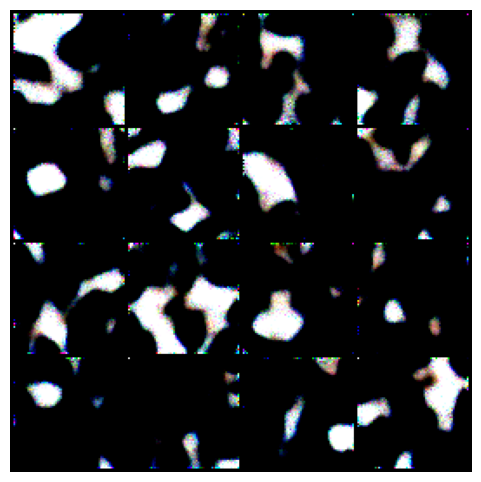

In [27]:
samples = sample(model, n=16)
samples = (samples.clamp(-1, 1) + 1) / 2

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

grid = make_grid(samples, nrow=4)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()


In [16]:
from torchvision.utils import save_image

save_image(samples, "/content/cv_image.jpeg", nrow=4)